In [1]:
import pandas as pd
import numpy as np
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, DrawingArea, OffsetImage, AnnotationBbox
from scipy.signal import butter, lfilter
from scipy.signal import butter, filtfilt
import os
from pathlib import Path

Import Files

Import all files from specified folder and assign the compounds applied in each. Folder should only contain files from a single plate and single injection, the datatable and trace for each.

In [2]:
path = r'/Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19' # use your path
data_tables = glob.glob(path + "/*screen_Datatable.dat") # use your extension
traces = glob.glob(path + "/*screen_Traces.dat") # use your extension

li = []
li2 = []

for filename in data_tables:
    df = pd.read_csv(filename, index_col=None, header=0, sep='\t') # for .dat files you must specify separation for example sep='\t'
    li.append(df)

for filename in traces:
    df_trace = pd.read_csv(filename, index_col=None, header=0, sep='\t') # for .dat files you must specify separation for example sep='\t'
    # Transpose the DataFrame
    df_trace_transposed = df_trace.transpose()
    # Create a new column for original column titles
    #df_trace_transposed.columns = df_trace_transposed.iloc[0]
    #df_trace_transposed = df_trace_transposed[1:].reset_index(drop=True)
    df_trace_transposed['recording_info'] = df_trace_transposed.index
    
    df_trace_transposed['filename'] = os.path.basename(filename)
    #df_trace_transposed['ID'] = df_trace_transposed['recording_info'].str[-3:]
    df_trace_transposed['ID'] = df_trace_transposed['recording_info'].str.split('-').str[-1]
    df_trace_transposed['unique_trace_ID'] = df_trace_transposed['filename'] + df_trace_transposed['ID']
    df_trace_transposed['type'] = df_trace_transposed['recording_info'].str[0:5]
    #Drop rows where 'Time(' appears in 'type'
    df_filtered = df_trace_transposed[df_trace_transposed['type'] != 'Time(']
    df_filtered.reset_index(drop=True, inplace=True)
    df_filtered.columns.name = 'Time (ms)'
    li2.append(df_filtered)

data_table = pd.concat(li, axis=0, ignore_index=True)
data_traces = pd.concat(li2, axis=0, ignore_index=True)
data_traces.columns.name = 'Time (ms)'

data_traces.head(5)

Time (ms),0,1,2,3,4,5,6,7,8,9,...,22785,22786,22787,22788,22789,22790,22791,22792,22793,22794
0,-30.0,-33.2,-31.6,-29.6,-31.4,-29.0,-27.3,-26.4,-29.5,-28.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-6.2,-7.0,-1.6,-5.3,0.9,0.2,0.0,-3.2,0.8,-4.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-6.4,-4.1,-1.4,-2.0,2.2,-1.6,-0.4,-0.6,-1.2,-2.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,-2.9,2.5,2.0,0.3,1.7,0.8,-2.2,-4.0,-3.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.5,-8.6,-2.6,1.1,-0.5,1.4,2.0,-1.9,-5.2,-3.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
duplicate_columns = data_traces.columns[data_traces.columns.duplicated()]

if len(duplicate_columns) == 0:
    print("No duplicated column names.")
else:
    print("Duplicated column names:", duplicate_columns.tolist())

No duplicated column names.


In [4]:
# Column names based on the standard column titles from Robocyte2+ software export
selected_columns = ['Well', 'Buffer', 'Comp. 1', 'conc. 1', 'unit 1', 'Minimum', 'Baseline Average', 'ID']

# Select columns and create a copy to avoid chained assignment warning
data_table_info = data_table[selected_columns].copy()

# Transform units to µM scale
conditions = [
    (data_table_info['unit 1'] == 'mM'),
    (data_table_info['unit 1'] == 'µM'),
    (data_table_info['unit 1'] == 'nM')
]

choices = ['1000', '1', '0.001']

# Use .loc to set values for the 'factor' column
data_table_info.loc[:, 'factor'] = np.select(conditions, choices, default='0').astype(float)

# Use .loc to set values for the 'Agonist_Concentration_µM' column
data_table_info.loc[:, 'Agonist_Concentration_µM'] = data_table_info['conc. 1'] * data_table_info['factor']

# Select final columns
final_columns = ['Well', 'Buffer', 'Comp. 1', 'Minimum', 'Agonist_Concentration_µM', 'ID']
data_table_info = data_table_info[final_columns]

# Reset index
data_table_info.reset_index(drop=True, inplace=True)

data_table_info.head(100)

,Well,Buffer,Comp. 1,Minimum,Agonist_Concentration_µM,ID
0,B5,ND96,ACh,-87,1000.0,126
1,B5,ND96,Ch,-19,1000.0,127
2,B5,ND96,Betaine,-16,1000.0,128
3,B5,ND96,Octopamine,-10,1000.0,129
4,B5,ND96,Tyramine,-35,1000.0,130
...,...,...,...,...,...,...
80,B9,ND96,Histamine,-52,1000.0,253
81,B9,ND96,tryptamine,-11550,1000.0,254
82,B9,ND96,Epinephrine,-11,1000.0,255
83,B9,ND96,PEOH,-80,1000.0,256


In [5]:
nan_count = data_traces['ID'].isna().sum()
print("Number of NaN values in 'ID' column:", nan_count)

Number of NaN values in 'ID' column: 0


In [7]:
# Convert 'ID' column to int64 in data_traces
data_traces['ID'] = data_traces['ID'].astype(int)
# Merging on the 'ID' column
merged_data = pd.merge(data_table_info, data_traces, on='ID')
merged_data['new_col_header'] = merged_data['Comp. 1'] + '_' + merged_data['Well'] + '_' + merged_data['ID'].astype(str)
merged_data.head()

,Well,Buffer,Comp. 1,Minimum,Agonist_Concentration_µM,ID,0,1,2,3,...,22786,22787,22788,22789,22790,22791,22792,22793,22794,new_col_header
0,B5,ND96,ACh,-87,1000.0,126,-10.7,-11.2,-15.1,-16.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ACh_B5_126
1,B5,ND96,Ch,-19,1000.0,127,-4.0,-5.0,-2.9,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ch_B5_127
2,B5,ND96,Betaine,-16,1000.0,128,-2.9,-3.0,-3.9,-0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Betaine_B5_128
3,B5,ND96,Octopamine,-10,1000.0,129,1.5,1.1,2.0,-0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Octopamine_B5_129
4,B5,ND96,Tyramine,-35,1000.0,130,-4.3,-3.8,-0.6,-2.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tyramine_B5_130


In [8]:
merged_data_T = merged_data.T
# Set 'new_col_header' as the new header
new_col_header_row = merged_data_T.iloc[-1]
merged_data_T.columns = new_col_header_row
# Drop the first 6 rows and set the last row as the header
merged_data_T = merged_data_T.iloc[6:]
# Drop the last 3 rows
merged_data_T = merged_data_T.iloc[:-3]
# Reset the index if needed
merged_data_T.reset_index(drop=True, inplace=True)
merged_data_T.columns.name = 'Time (ms)'
merged_data_T.head(100)

Time (ms),ACh_B5_126,Ch_B5_127,Betaine_B5_128,Octopamine_B5_129,Tyramine_B5_130,Dopamine_B5_131,Histamine_B5_132,Glutamate_B5_133,Epinephrine_B5_134,PEOH_B5_135,...,serotonin_B9_248,5-HTP_B9_249,Octopamine_B9_250,Tyramine_B9_251,Dopamine_B9_252,Histamine_B9_253,tryptamine_B9_254,Epinephrine_B9_255,PEOH_B9_256,2-aminophenylethanol_B9_257
0,-10.7,-4.0,-2.9,1.5,-4.3,1.1,-3.9,0.7,-2.3,1.5,...,-0.7,-4.3,0.9,-1.6,-3.2,2.7,-2.6,-13.9,1.1,-0.7
1,-11.2,-5.0,-3.0,1.1,-3.8,3.2,0.5,-1.3,-8.5,-0.6,...,2.0,-6.7,-0.8,-2.8,-3.2,2.9,-3.9,-14.6,2.3,0.8
2,-15.1,-2.9,-3.9,2.0,-0.6,2.0,-2.8,-3.3,-1.5,-2.4,...,1.5,-1.4,0.1,-3.7,-3.4,2.0,-4.1,-10.3,0.1,-3.6
3,-16.3,-1.0,-0.2,-0.9,-2.7,0.3,0.6,-2.9,-4.6,-4.1,...,2.2,-5.6,-2.8,-0.3,0.4,-1.2,-0.9,-13.2,-0.1,-3.8
4,-18.0,-3.4,-2.5,-1.9,2.1,2.3,2.5,-2.4,6.8,-0.4,...,-0.4,1.0,-3.8,-3.4,0.1,-2.7,-2.5,-9.6,0.9,-7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-14.1,1.1,2.8,-3.0,4.0,-2.3,2.1,1.3,2.7,-1.1,...,3.7,-1.0,-5.8,2.4,1.8,-3.2,2.3,-13.8,0.0,-3.8
96,-12.4,2.2,2.8,-1.1,2.1,-1.3,0.8,0.4,1.1,2.1,...,-1.3,0.8,-0.8,1.0,4.3,0.5,0.9,-8.2,-4.7,-3.9
97,-12.0,-0.1,2.8,-1.4,-0.6,-4.0,1.2,3.2,1.2,2.6,...,-4.0,-1.2,-0.5,2.4,1.8,-0.2,1.2,-14.5,-3.6,-1.8
98,-10.4,0.7,-0.3,0.9,0.8,-0.8,-1.1,-0.5,2.2,2.6,...,-4.4,0.5,-0.4,-0.2,0.4,3.0,0.2,-15.9,-3.6,-1.0


In [9]:
#define filter
cutoff = 50 #Hz above which to remove
Fs = 5000 #Hz sample
Wn = cutoff / (Fs / 2.0)
b, a = butter(N=4, Wn=Wn, btype='low', analog=False, output='ba')
# Apply the filter to each column
merged_data_filtered = merged_data_T.apply(lambda col: lfilter(b, a, col))
merged_data_filtered.head()

TypeError: can't multiply sequence by non-int of type 'float'

In [10]:
#SELECT DATA
df = merged_data_T

# SAVE PLOTS?
save = True  # Change to False if you don't want to save the plots
# Define scale
maxy = 10000
maxx = len(df) /1000
scale_bar_length = 2 #seconds
scale_bar_height = maxy / 10 #n amps
# Calculate the position and size of the scale bar

# Directory to save PDF files
path2 = Path(path)  # use your path
output_folder = path2 / 'output_plots'

# Create the output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

# Define a function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Apply pd.to_numeric with a custom function to filter non-numeric values for the whole DataFrame
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce').where(x.apply(is_numeric)))

# Drop rows with any NaN values
df = df.dropna()

df.head(100)

Time (ms),ACh_B5_126,Ch_B5_127,Betaine_B5_128,Octopamine_B5_129,Tyramine_B5_130,Dopamine_B5_131,Histamine_B5_132,Glutamate_B5_133,Epinephrine_B5_134,PEOH_B5_135,...,serotonin_B9_248,5-HTP_B9_249,Octopamine_B9_250,Tyramine_B9_251,Dopamine_B9_252,Histamine_B9_253,tryptamine_B9_254,Epinephrine_B9_255,PEOH_B9_256,2-aminophenylethanol_B9_257
0,-10.7,-4.0,-2.9,1.5,-4.3,1.1,-3.9,0.7,-2.3,1.5,...,-0.7,-4.3,0.9,-1.6,-3.2,2.7,-2.6,-13.9,1.1,-0.7
1,-11.2,-5.0,-3.0,1.1,-3.8,3.2,0.5,-1.3,-8.5,-0.6,...,2.0,-6.7,-0.8,-2.8,-3.2,2.9,-3.9,-14.6,2.3,0.8
2,-15.1,-2.9,-3.9,2.0,-0.6,2.0,-2.8,-3.3,-1.5,-2.4,...,1.5,-1.4,0.1,-3.7,-3.4,2.0,-4.1,-10.3,0.1,-3.6
3,-16.3,-1.0,-0.2,-0.9,-2.7,0.3,0.6,-2.9,-4.6,-4.1,...,2.2,-5.6,-2.8,-0.3,0.4,-1.2,-0.9,-13.2,-0.1,-3.8
4,-18.0,-3.4,-2.5,-1.9,2.1,2.3,2.5,-2.4,6.8,-0.4,...,-0.4,1.0,-3.8,-3.4,0.1,-2.7,-2.5,-9.6,0.9,-7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-14.1,1.1,2.8,-3.0,4.0,-2.3,2.1,1.3,2.7,-1.1,...,3.7,-1.0,-5.8,2.4,1.8,-3.2,2.3,-13.8,0.0,-3.8
96,-12.4,2.2,2.8,-1.1,2.1,-1.3,0.8,0.4,1.1,2.1,...,-1.3,0.8,-0.8,1.0,4.3,0.5,0.9,-8.2,-4.7,-3.9
97,-12.0,-0.1,2.8,-1.4,-0.6,-4.0,1.2,3.2,1.2,2.6,...,-4.0,-1.2,-0.5,2.4,1.8,-0.2,1.2,-14.5,-3.6,-1.8
98,-10.4,0.7,-0.3,0.9,0.8,-0.8,-1.1,-0.5,2.2,2.6,...,-4.4,0.5,-0.4,-0.2,0.4,3.0,0.2,-15.9,-3.6,-1.0


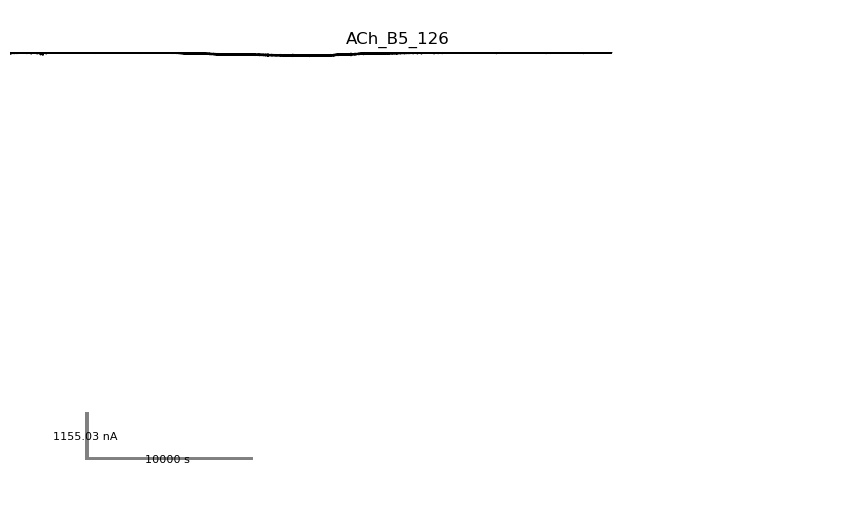

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


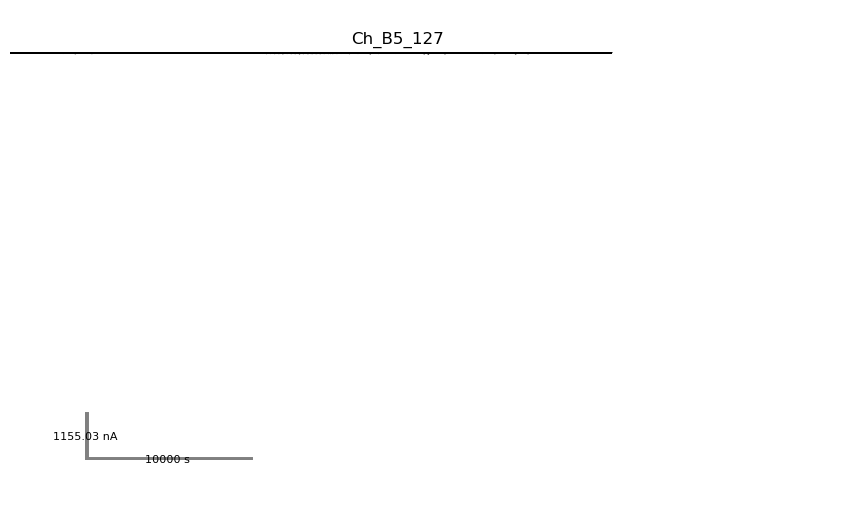

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


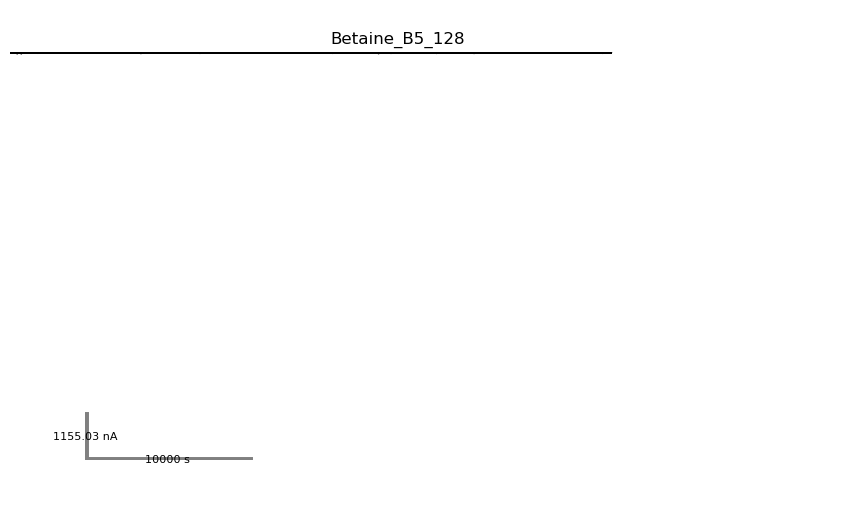

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


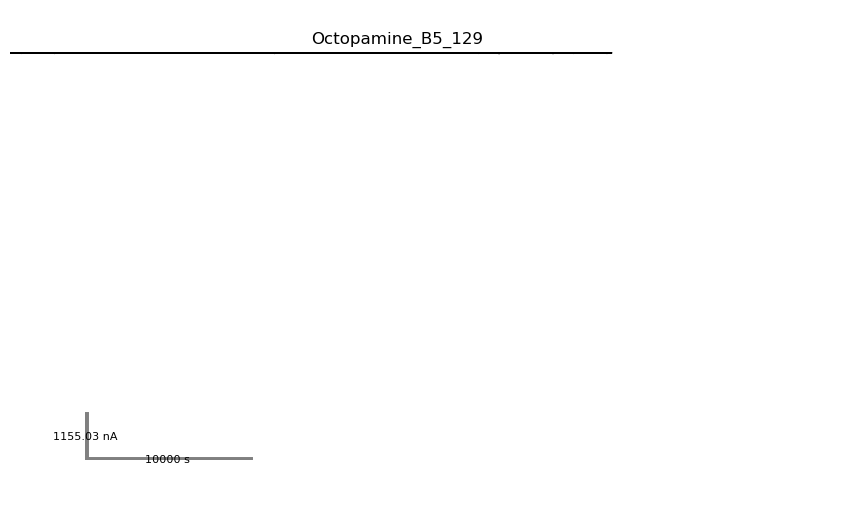

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


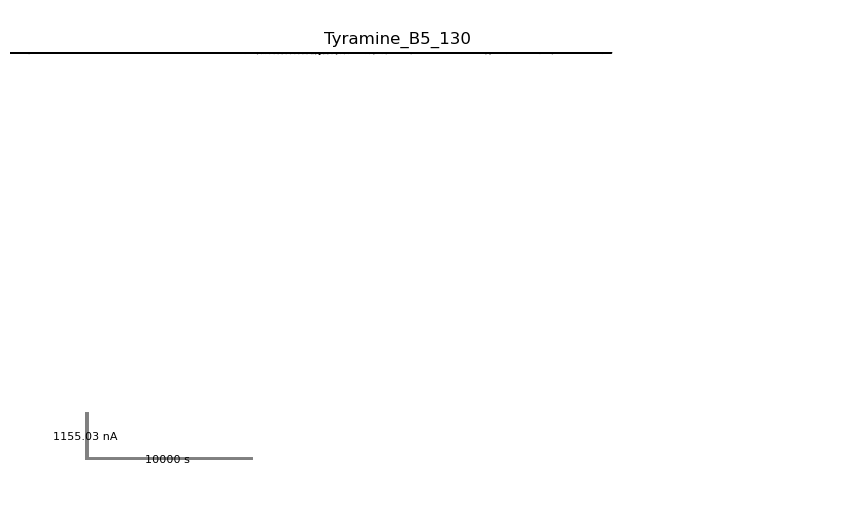

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


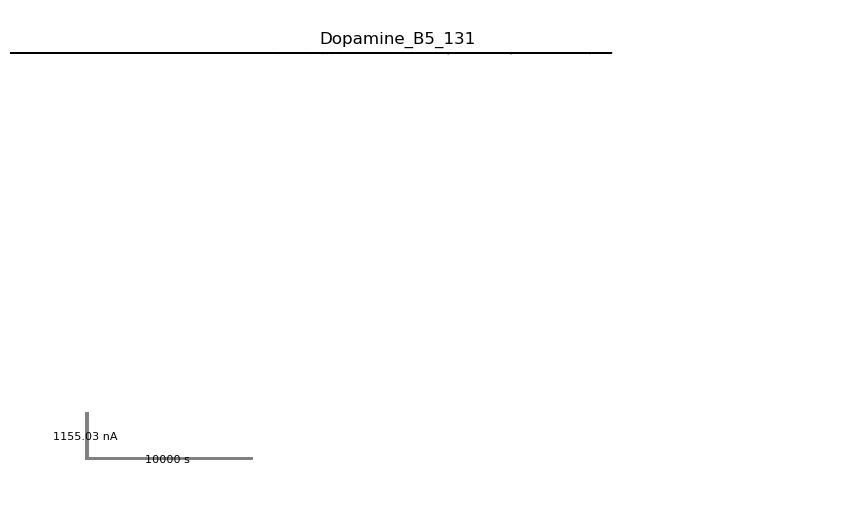

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


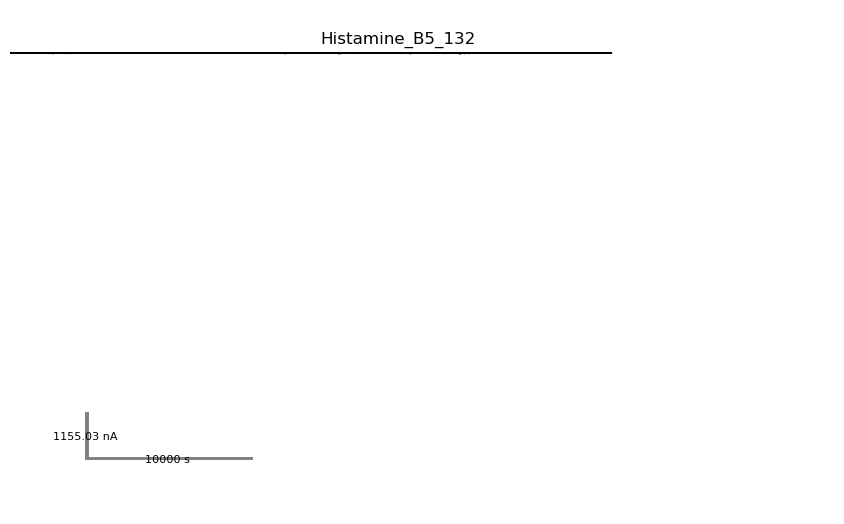

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


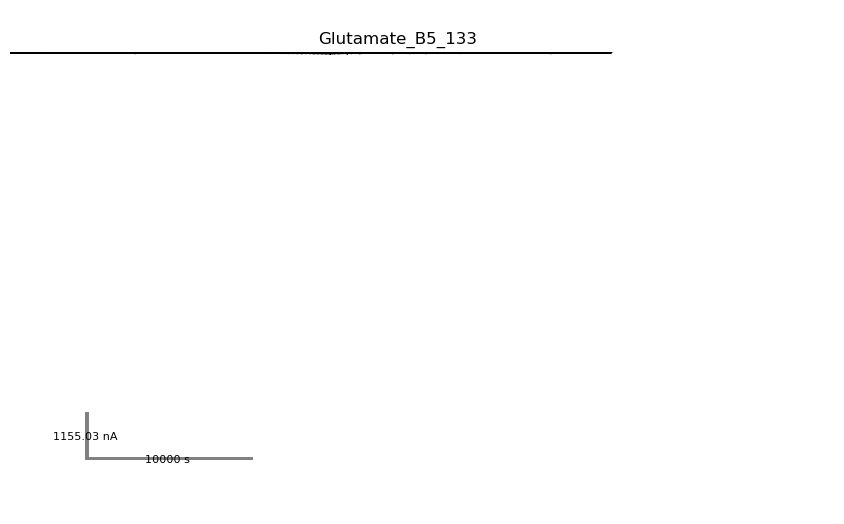

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


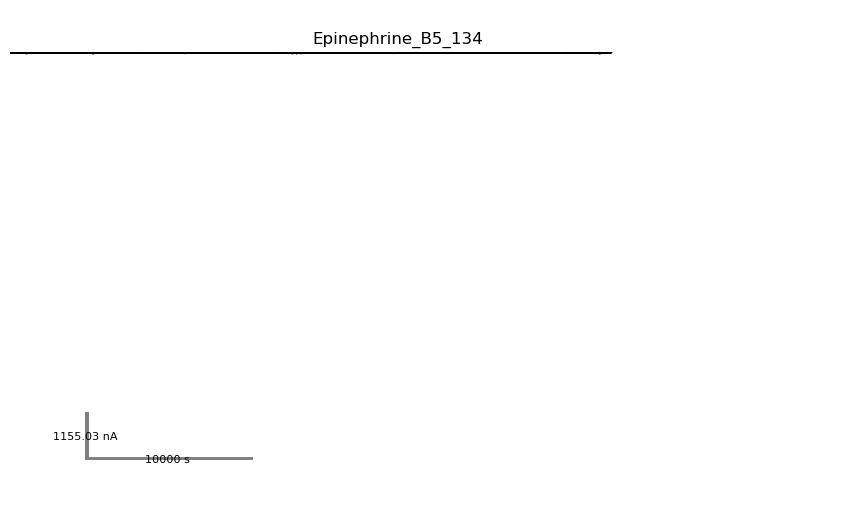

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


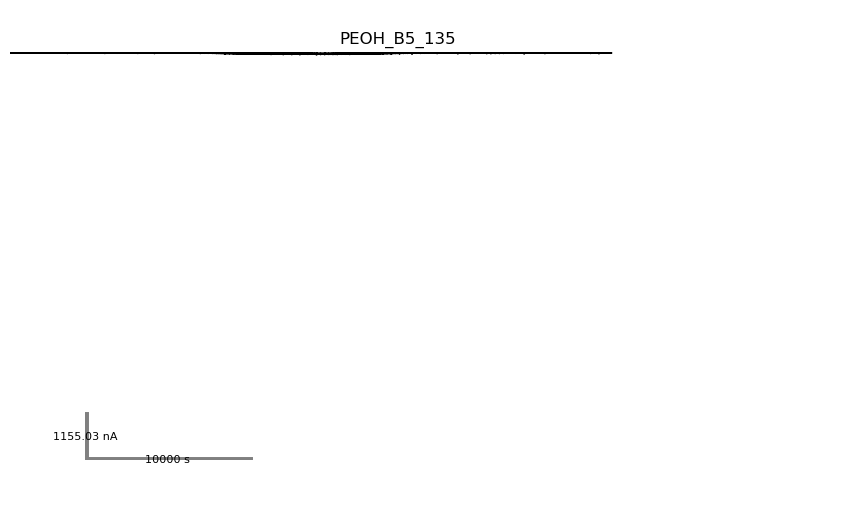

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


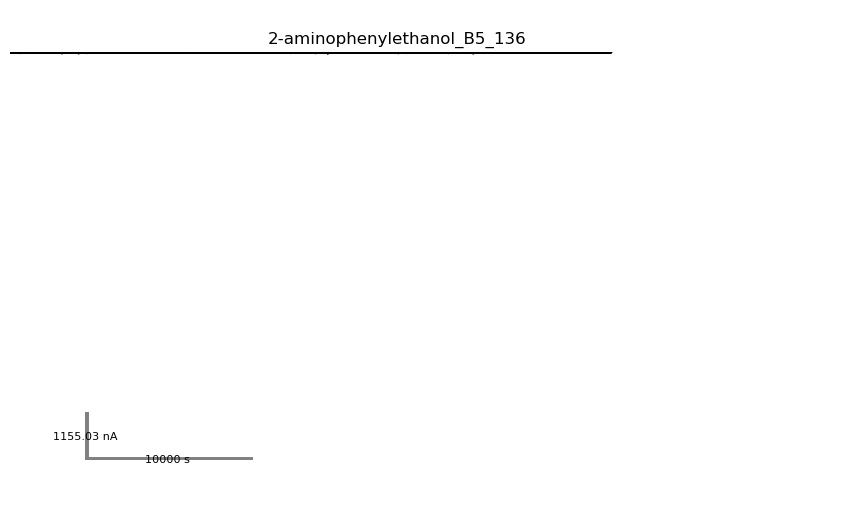

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


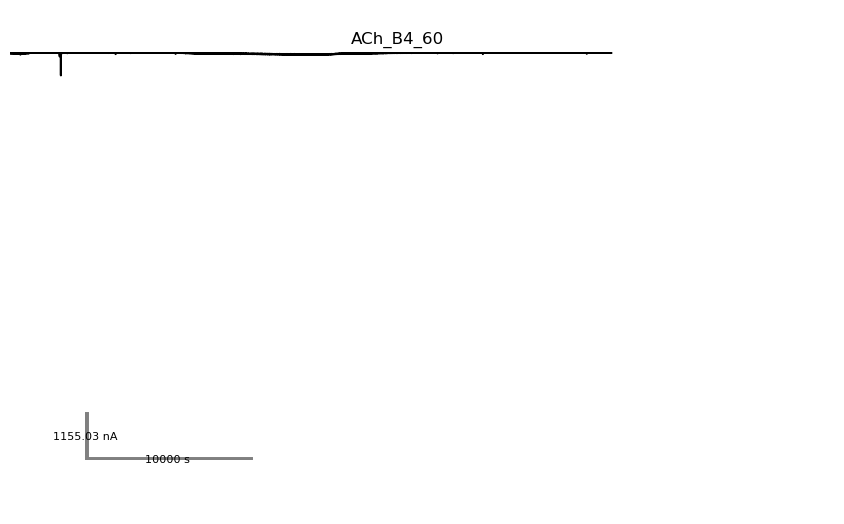

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


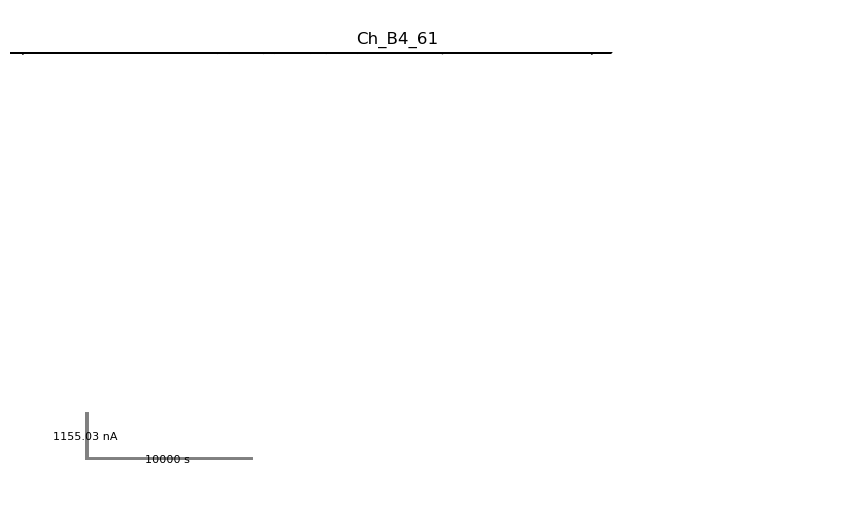

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


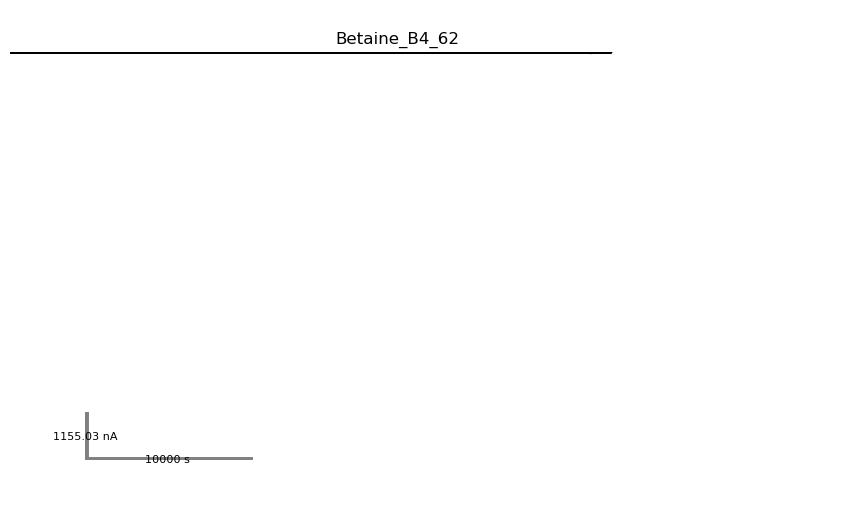

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


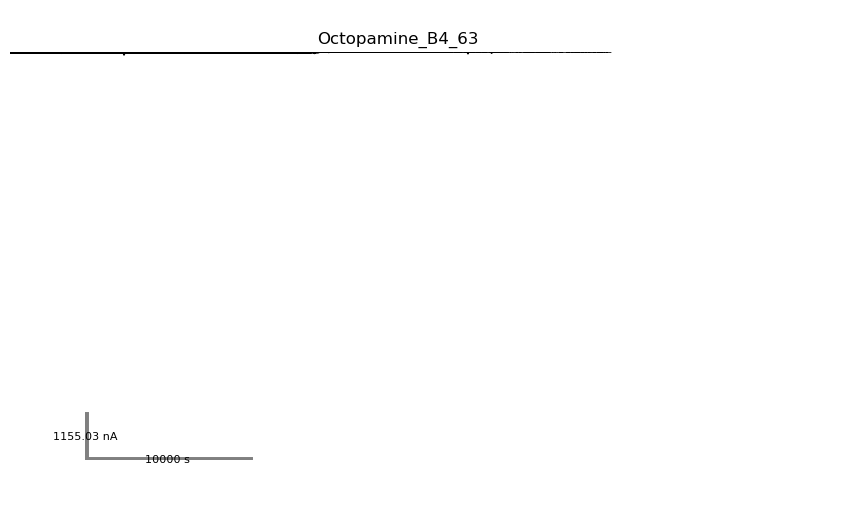

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


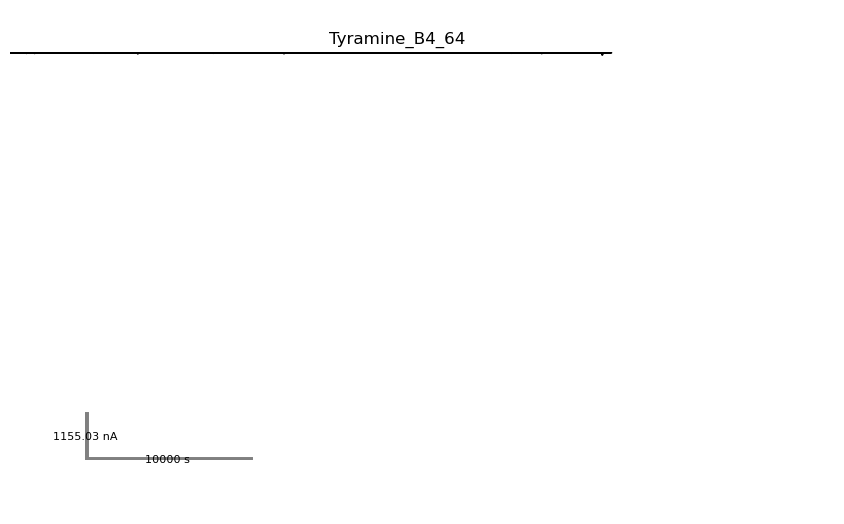

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


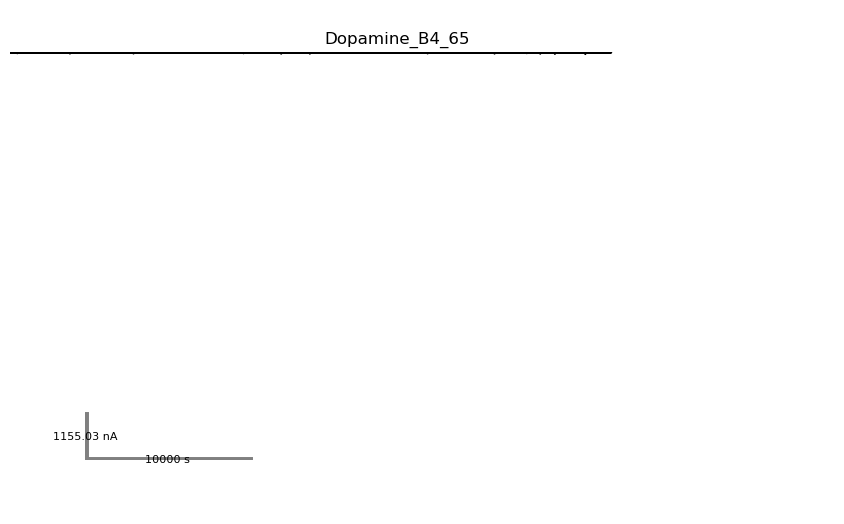

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


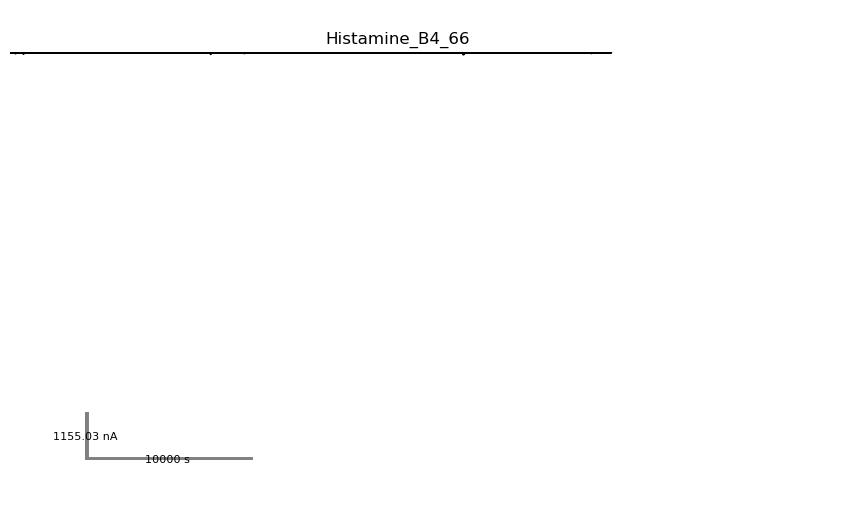

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


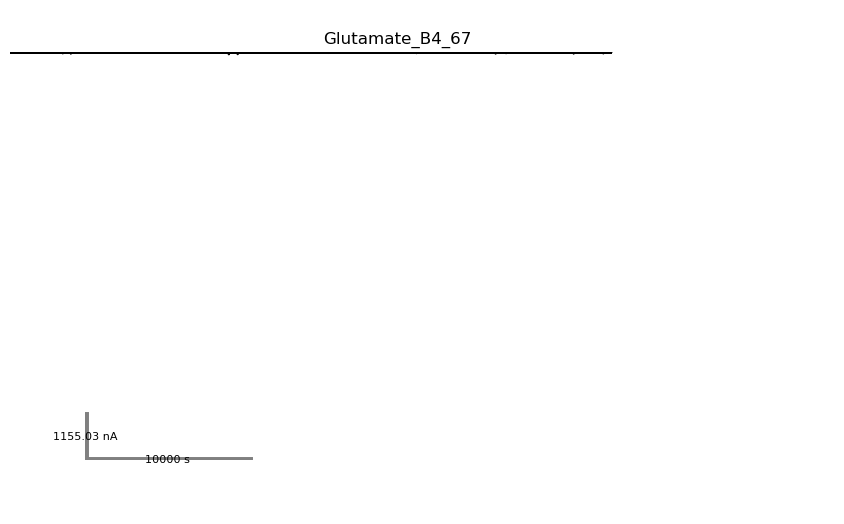

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


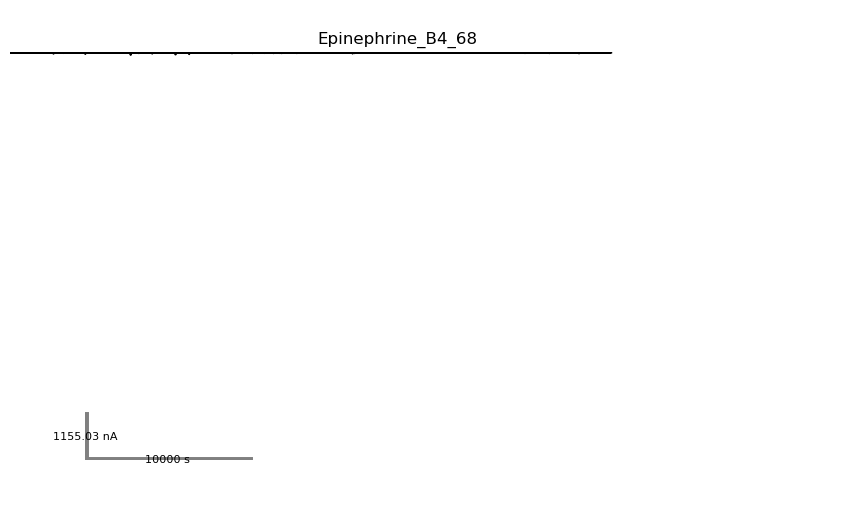

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


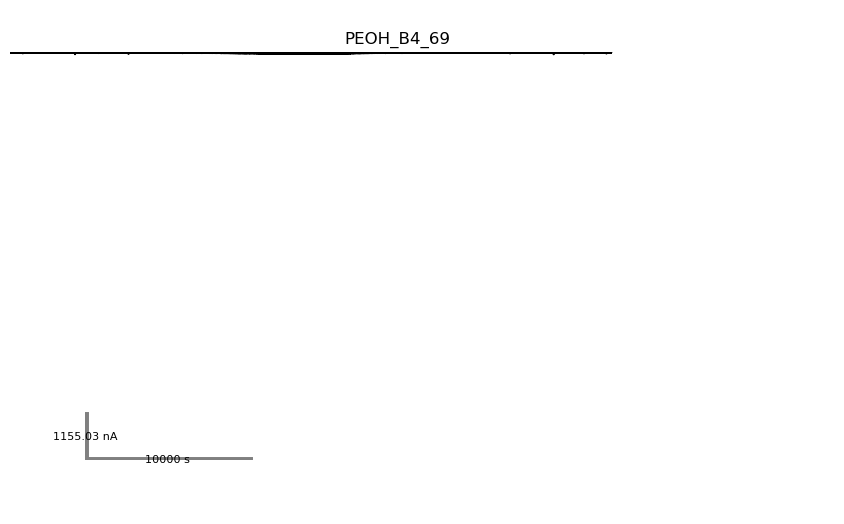

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


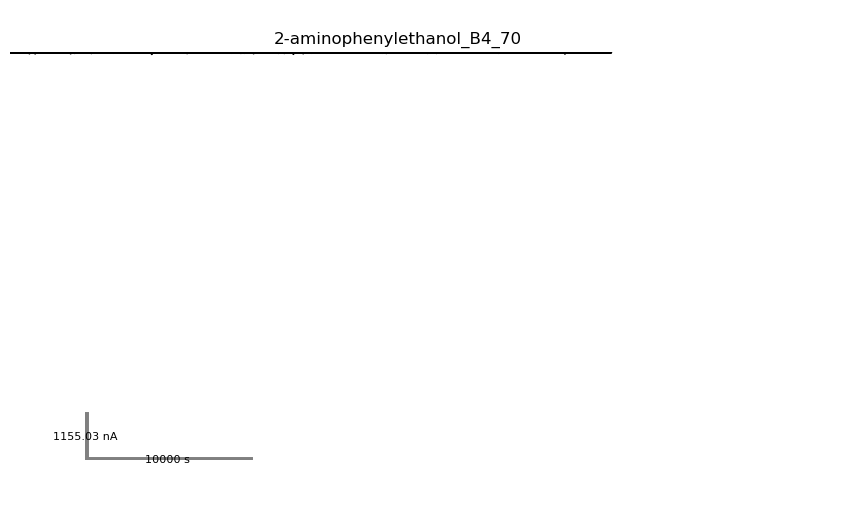

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


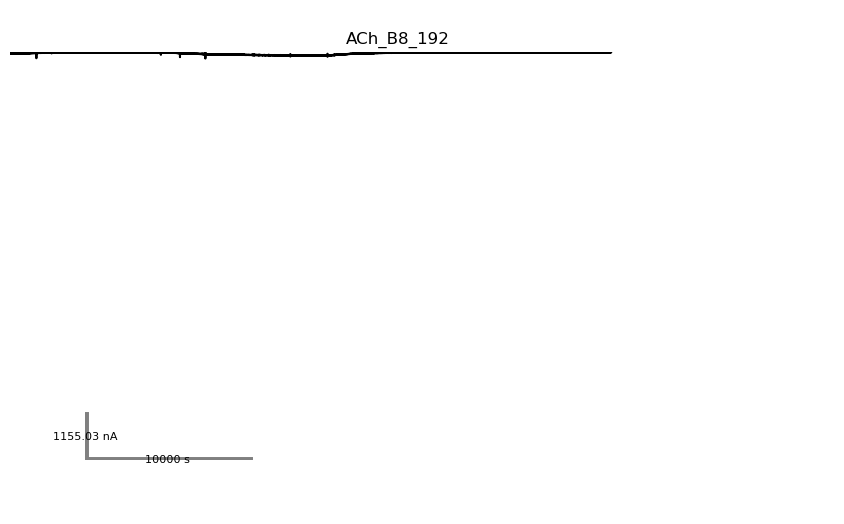

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


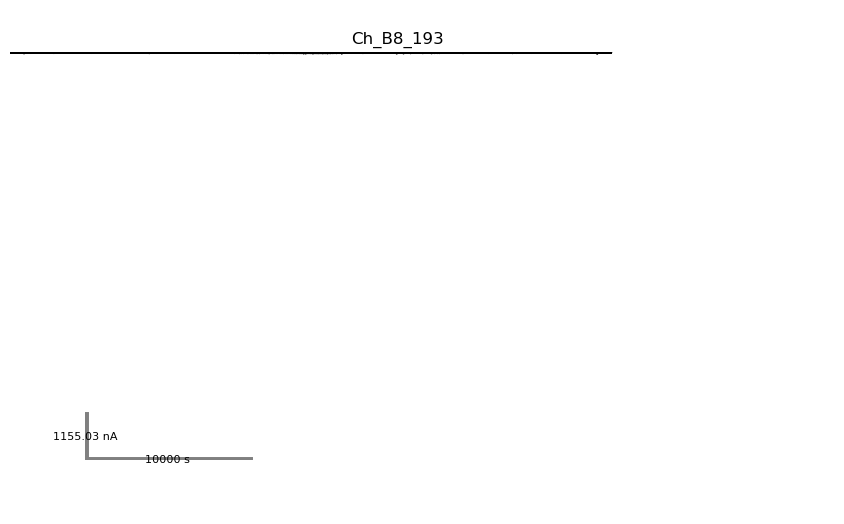

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


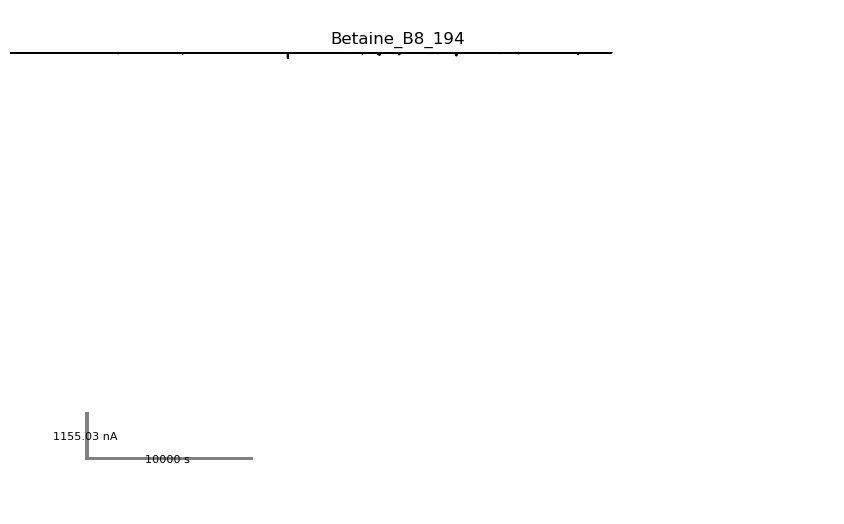

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


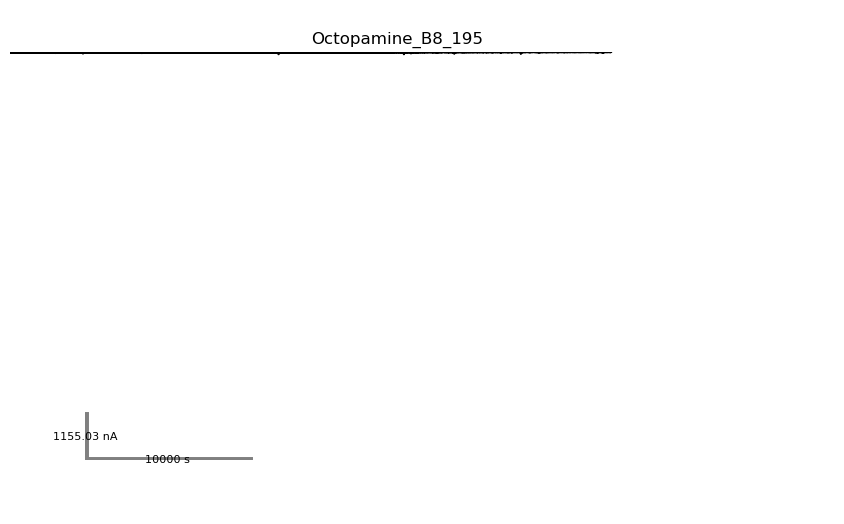

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


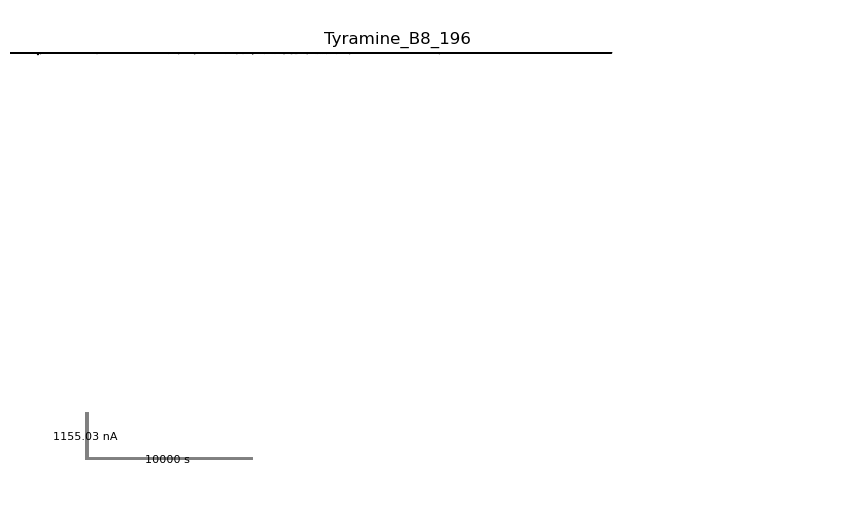

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


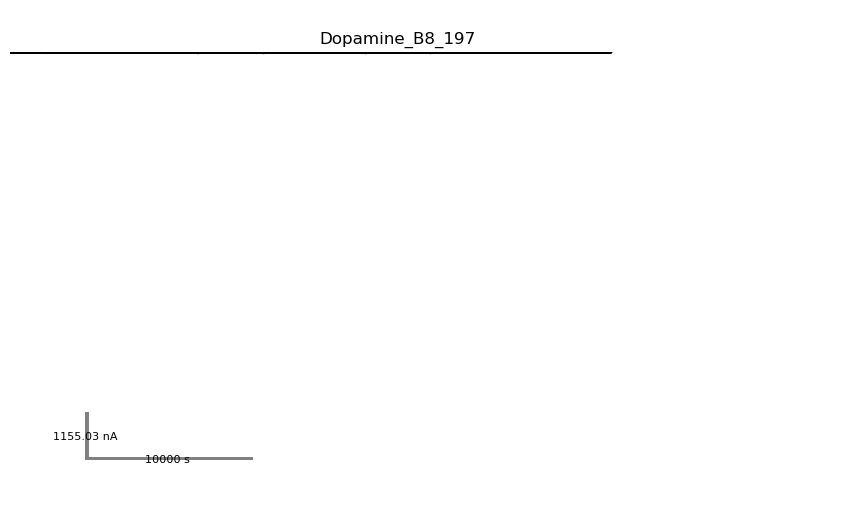

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


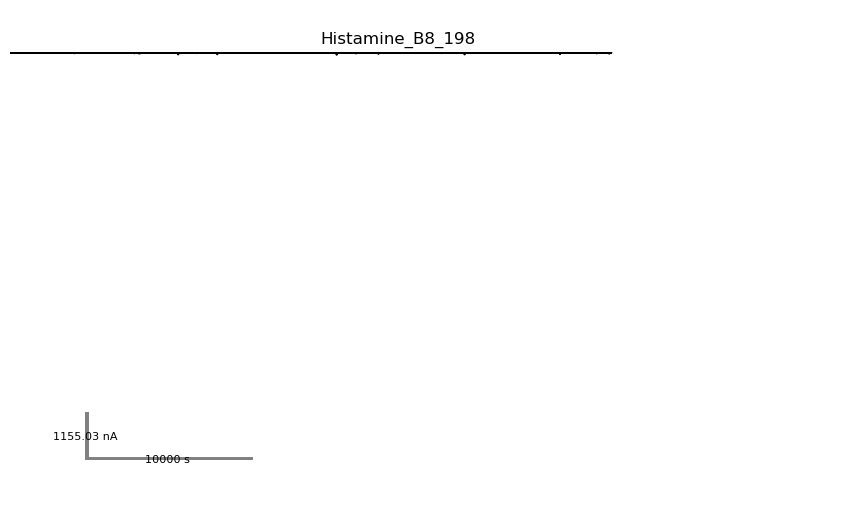

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


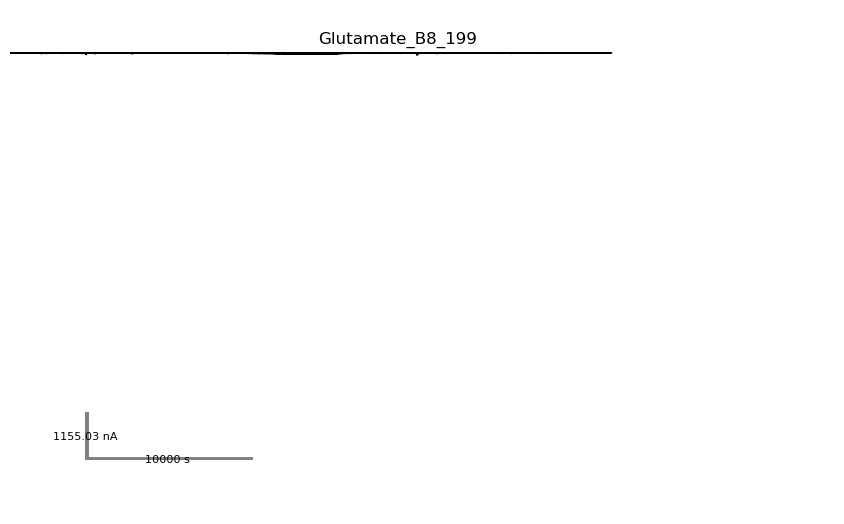

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


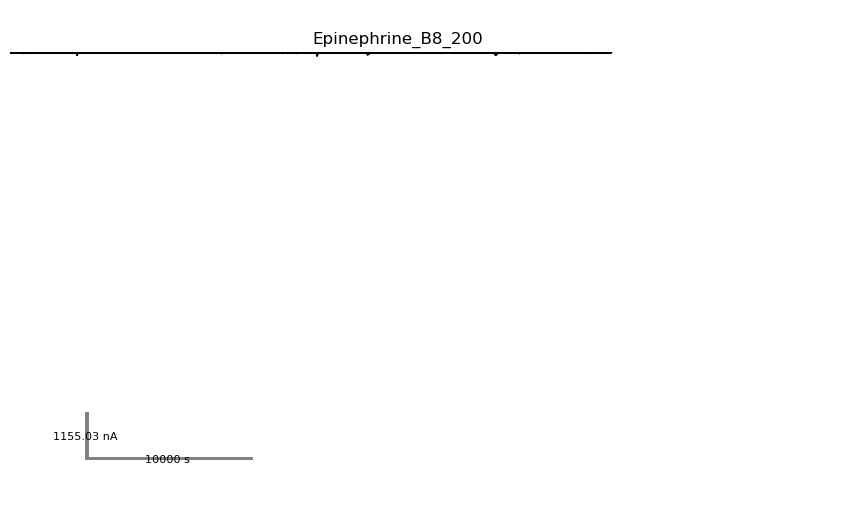

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


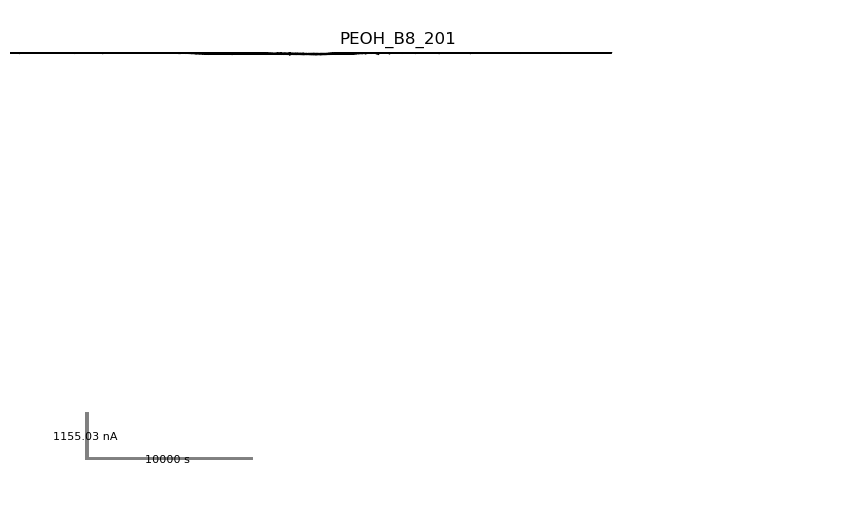

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


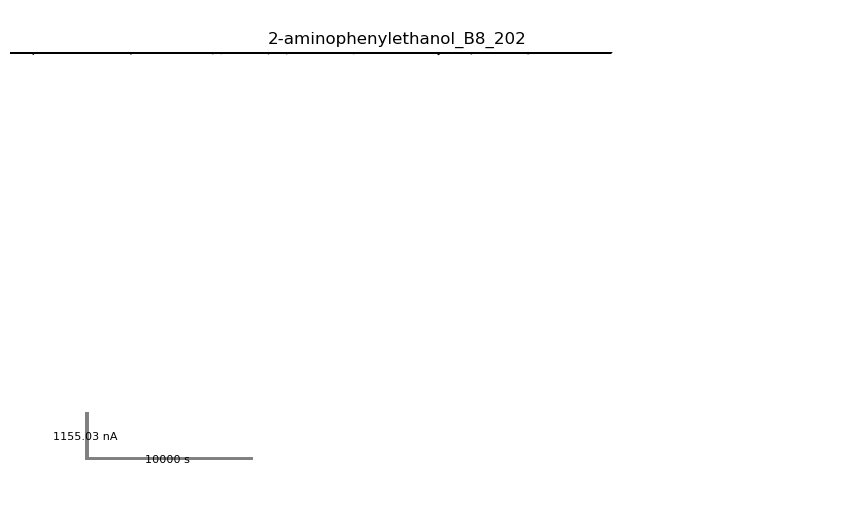

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


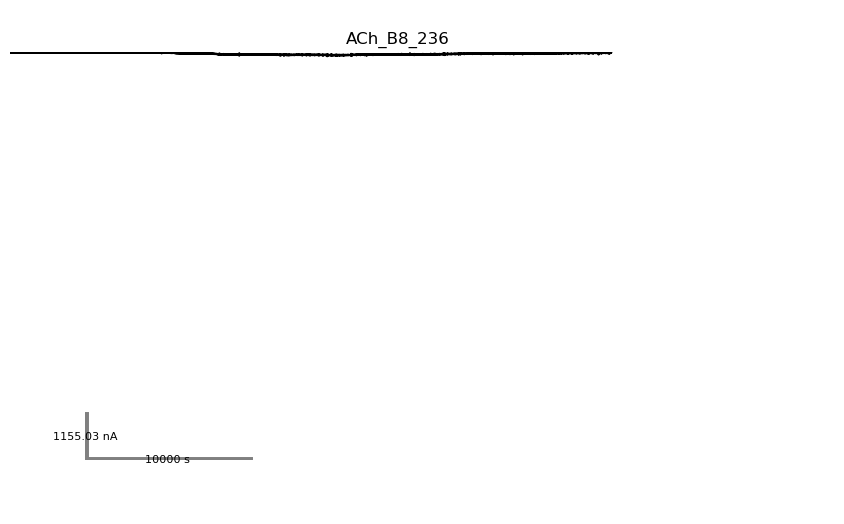

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


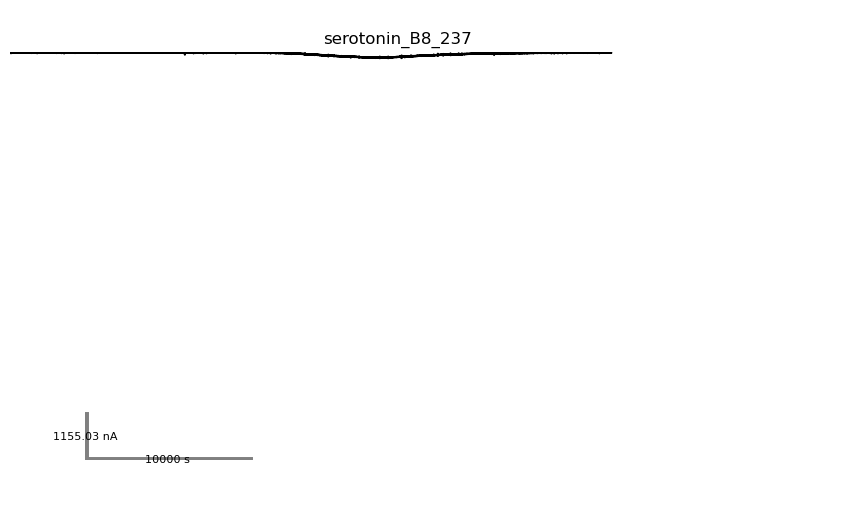

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


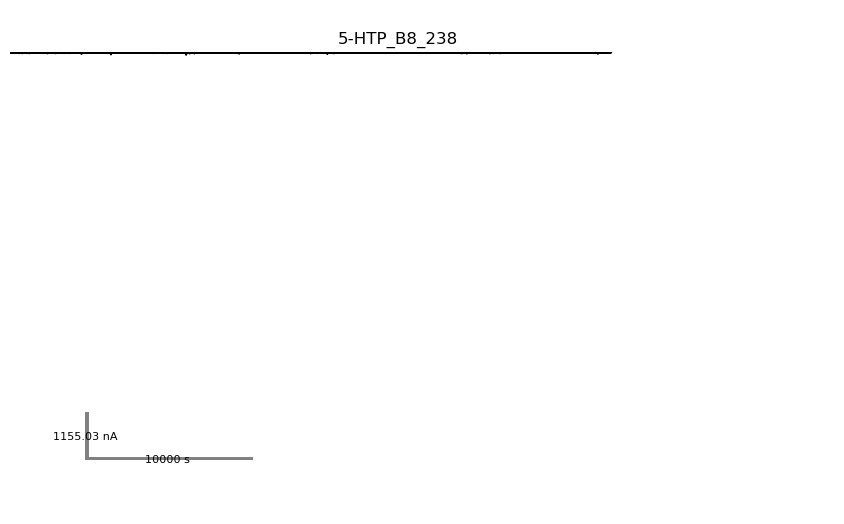

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


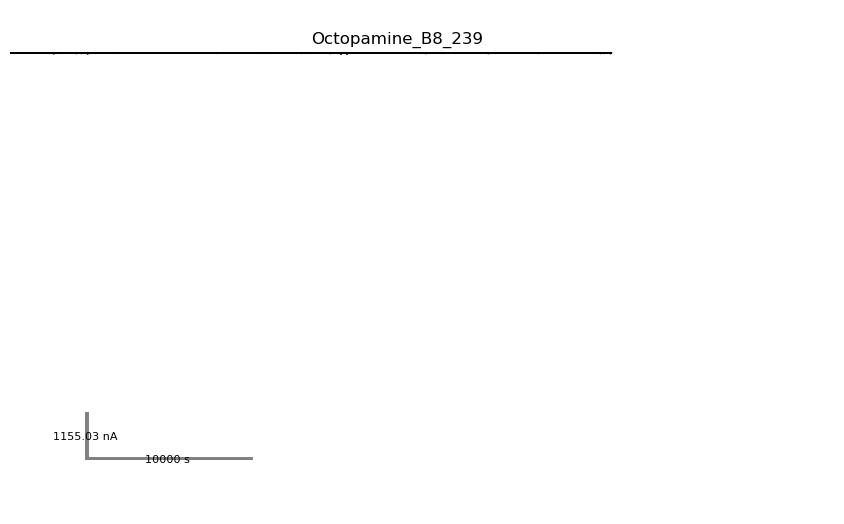

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


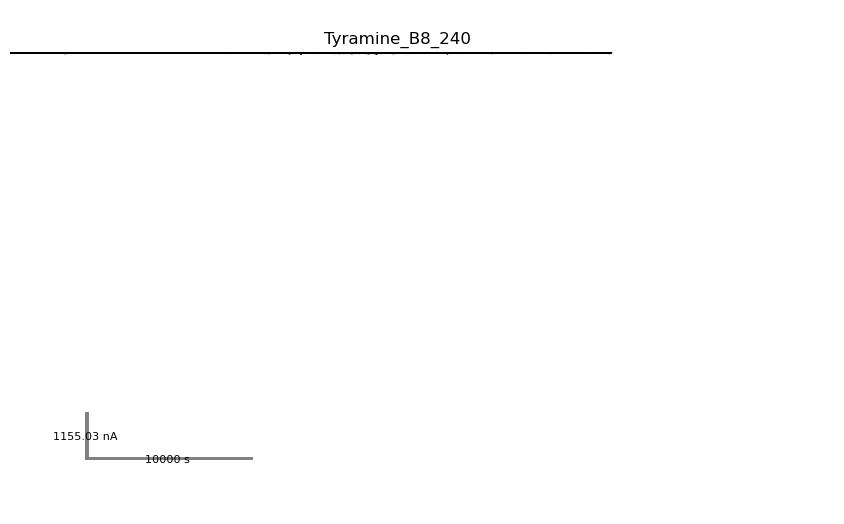

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


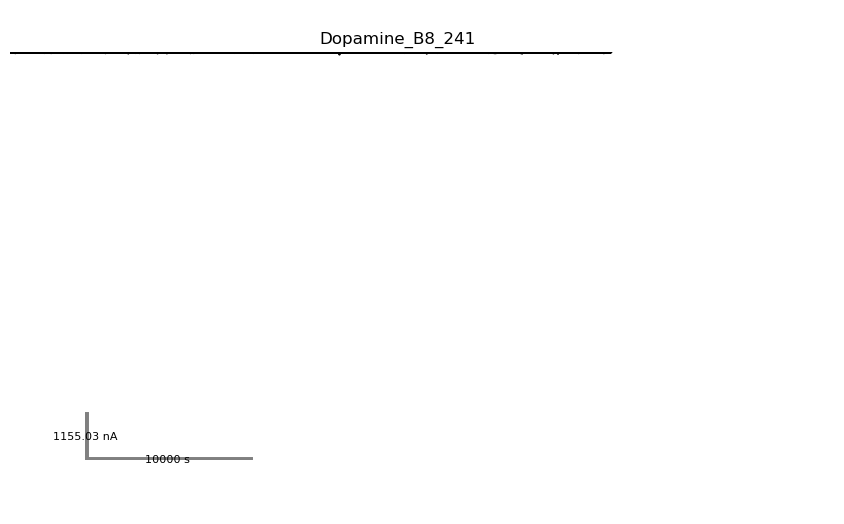

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


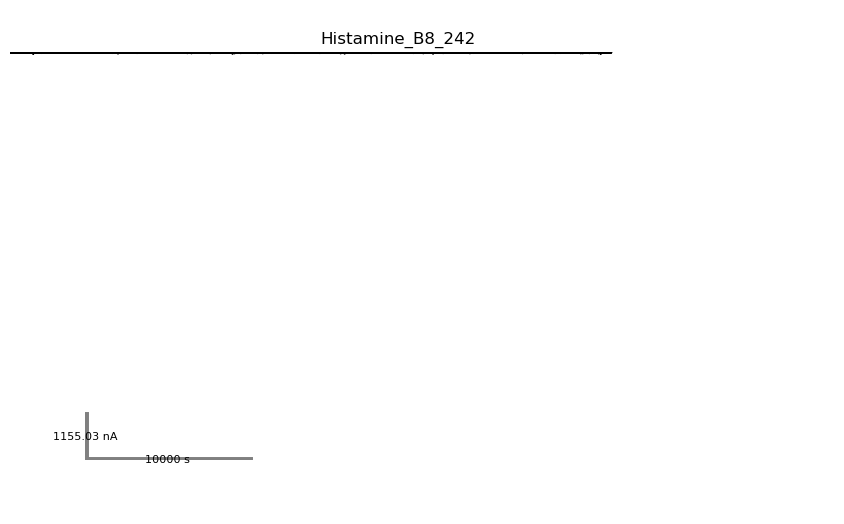

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


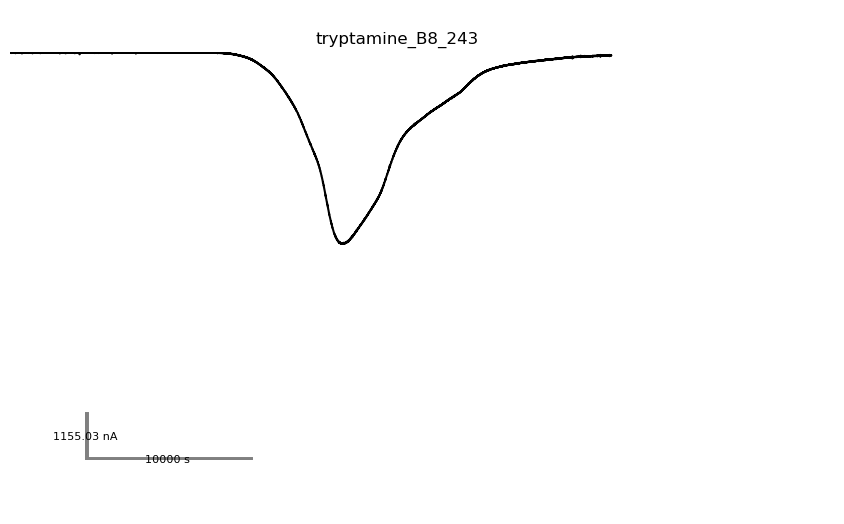

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


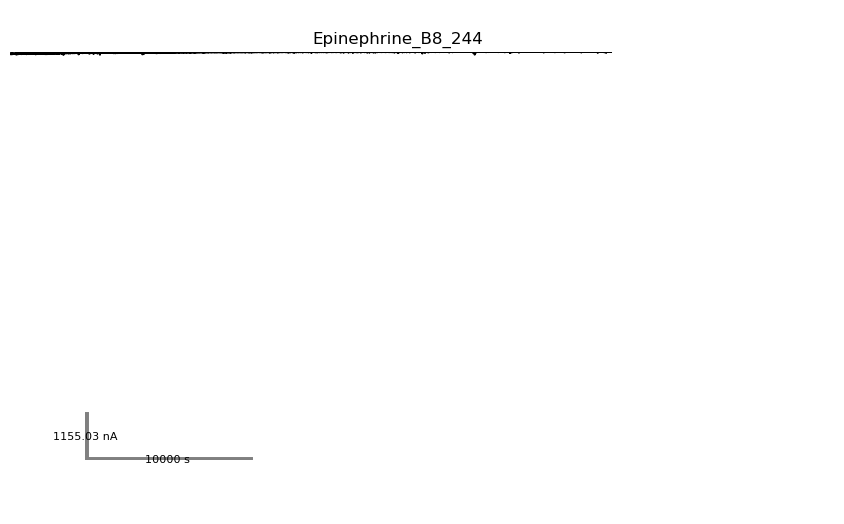

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


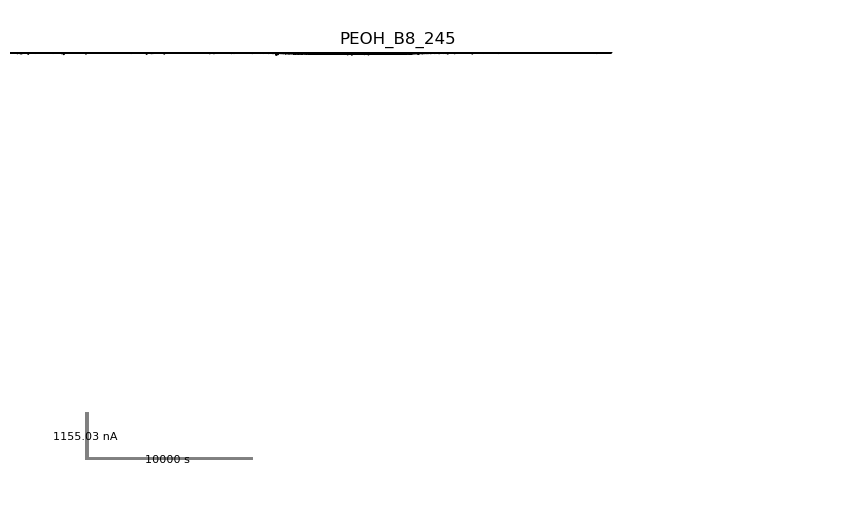

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


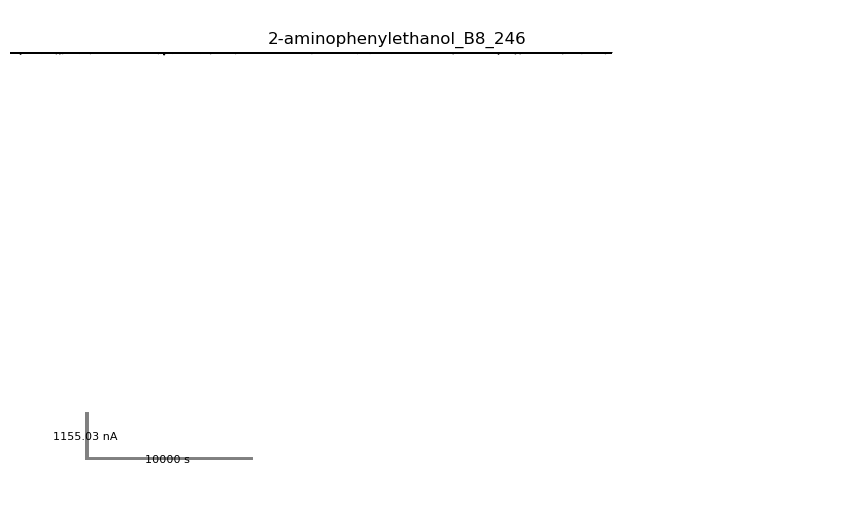

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


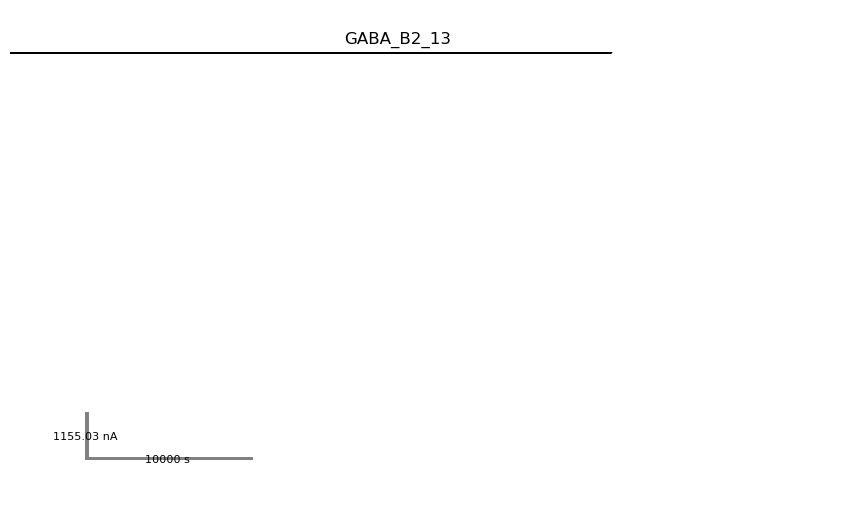

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


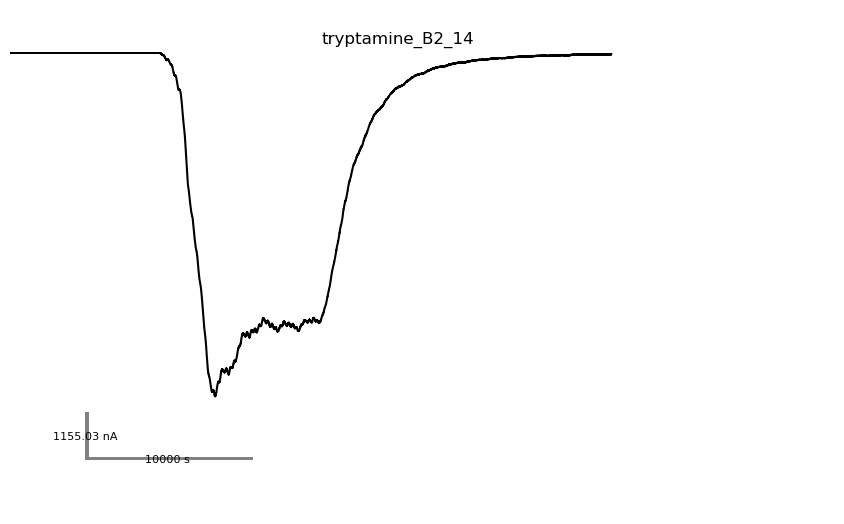

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


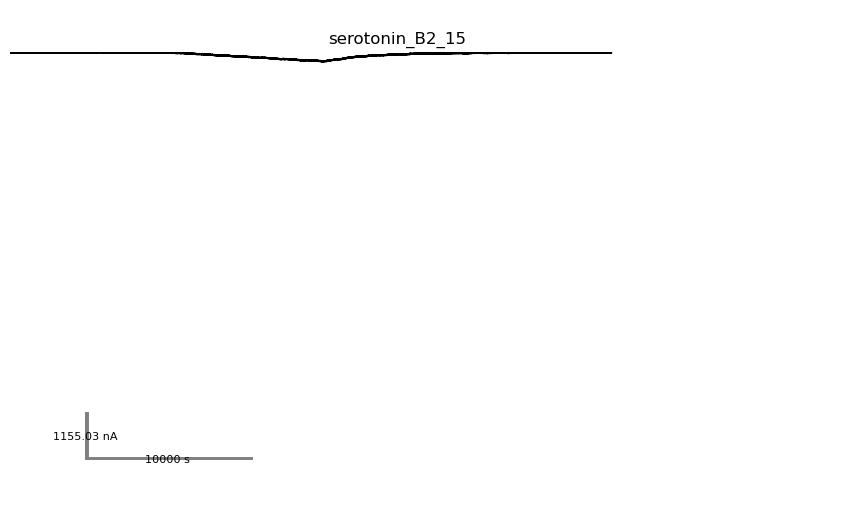

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


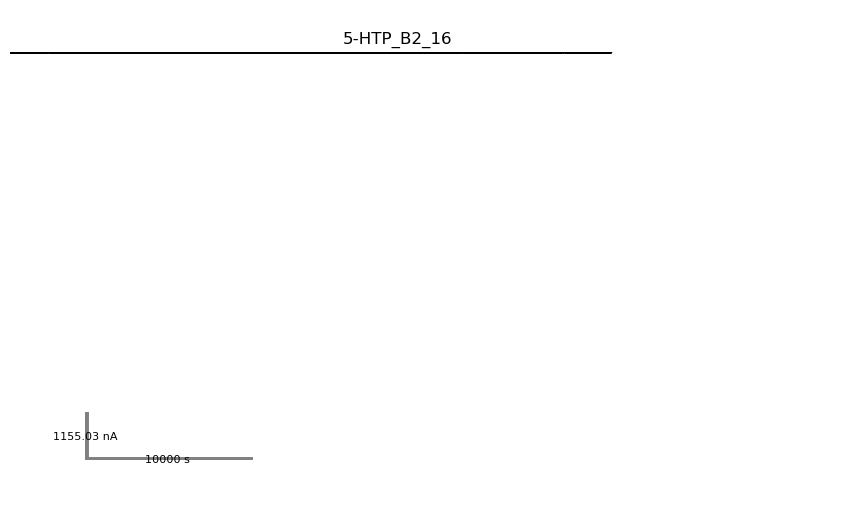

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


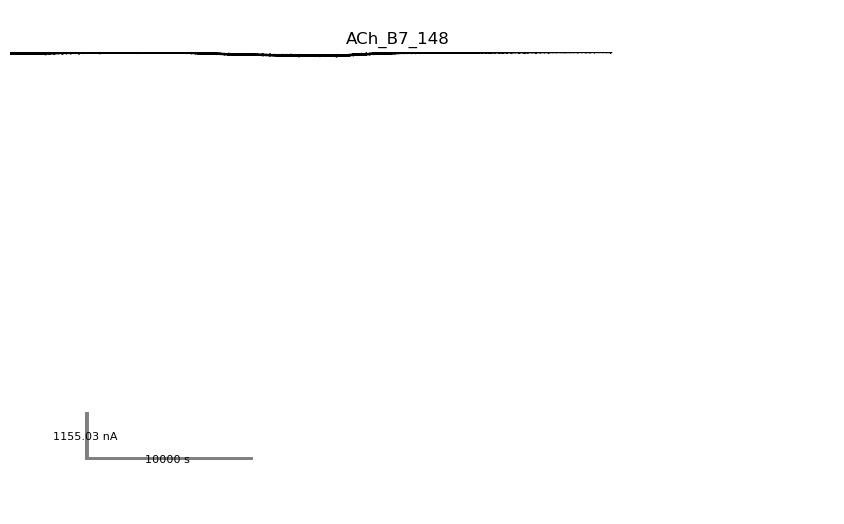

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


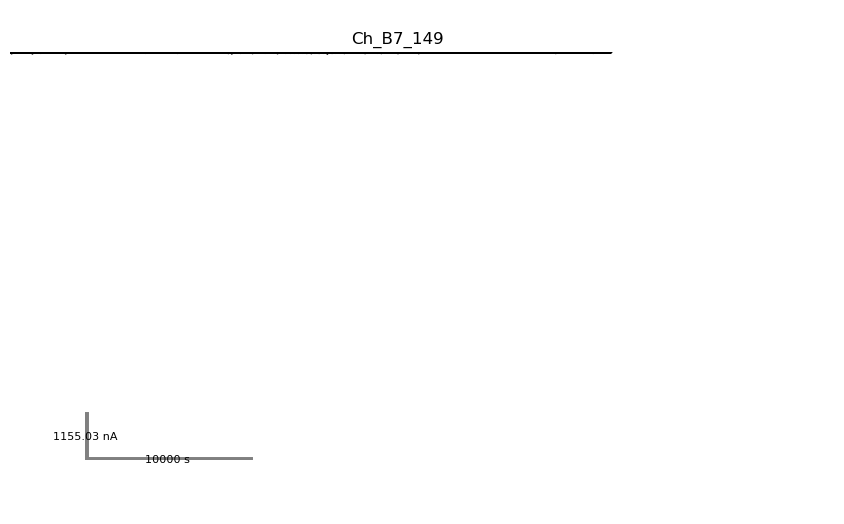

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


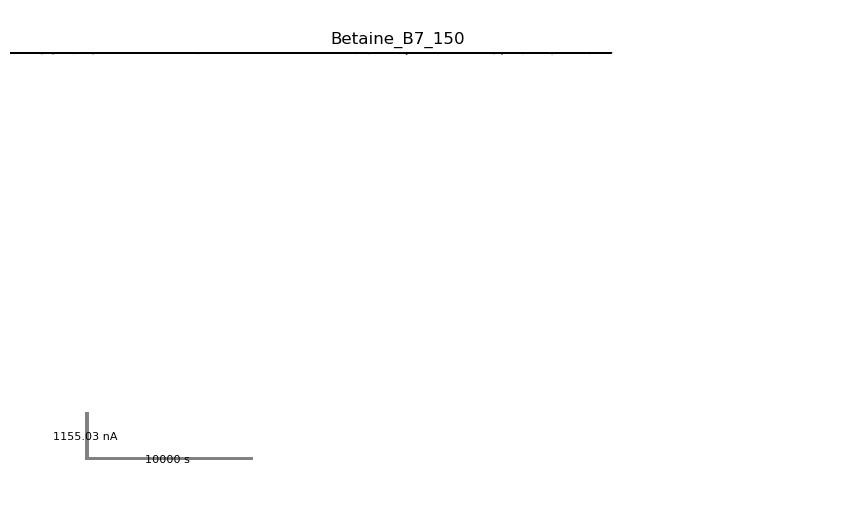

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


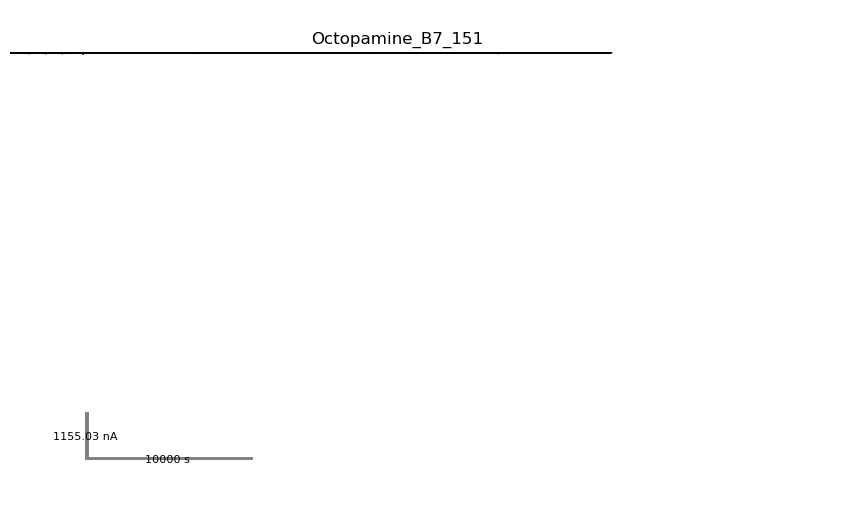

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


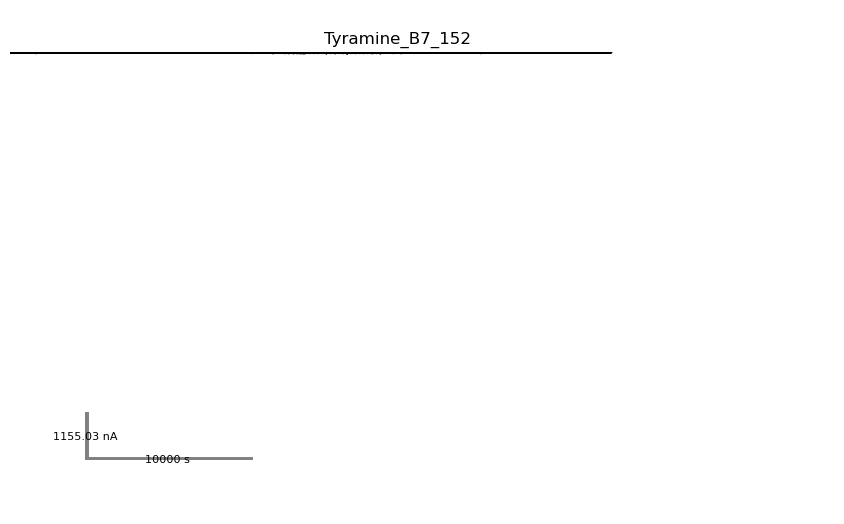

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


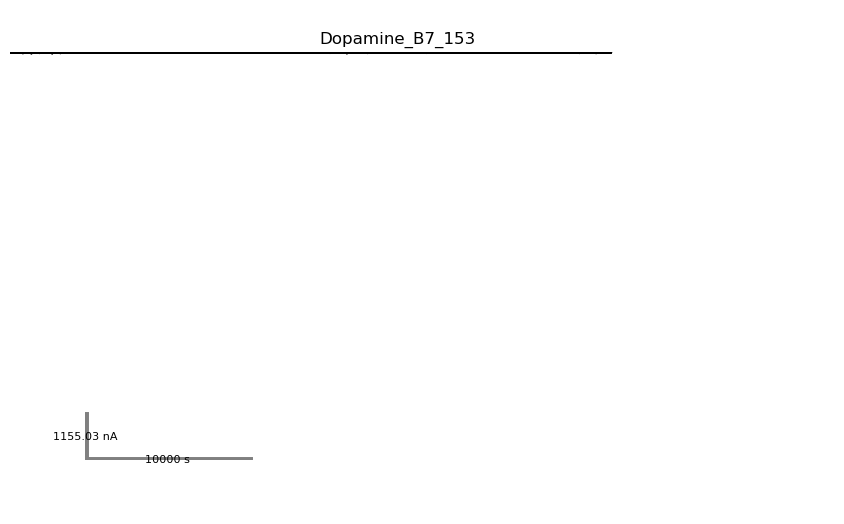

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


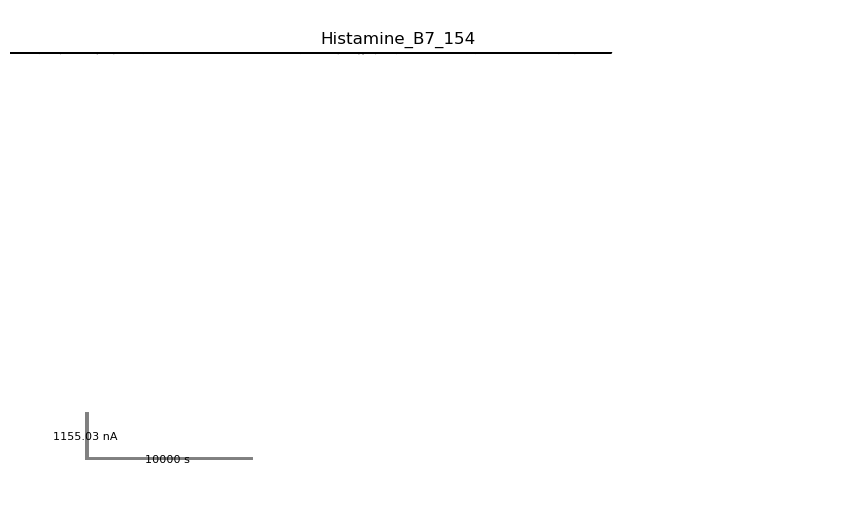

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


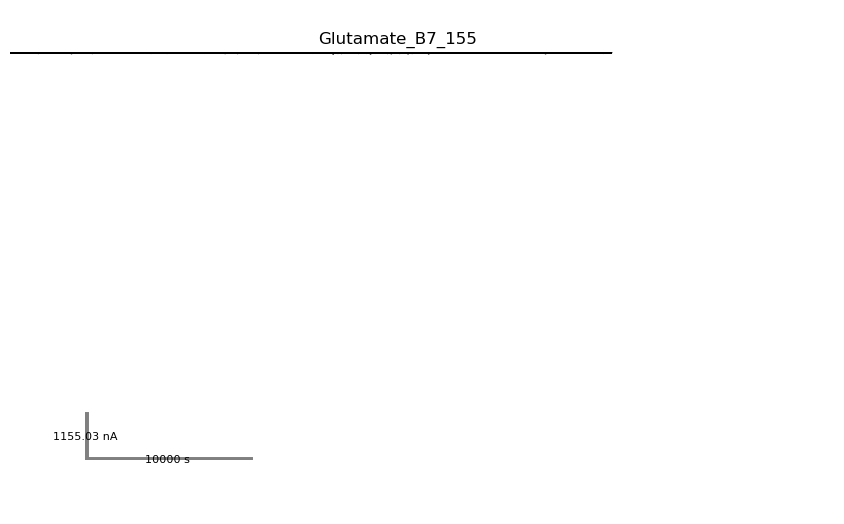

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


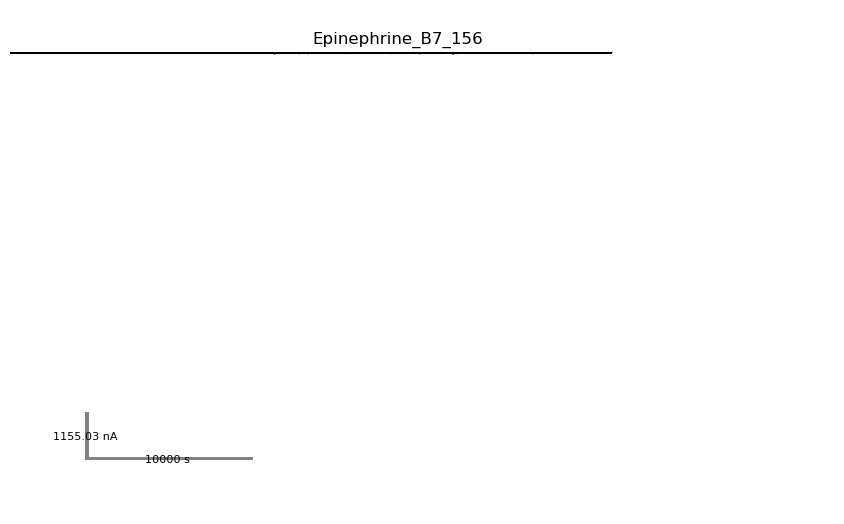

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


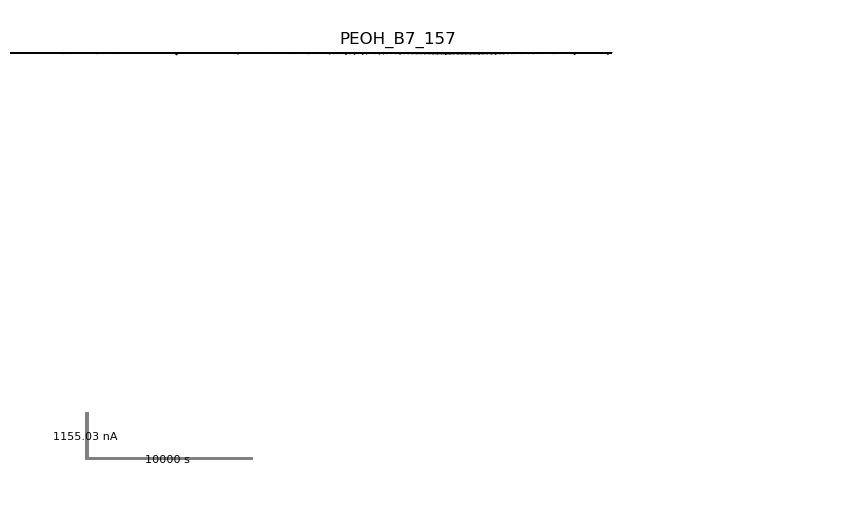

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


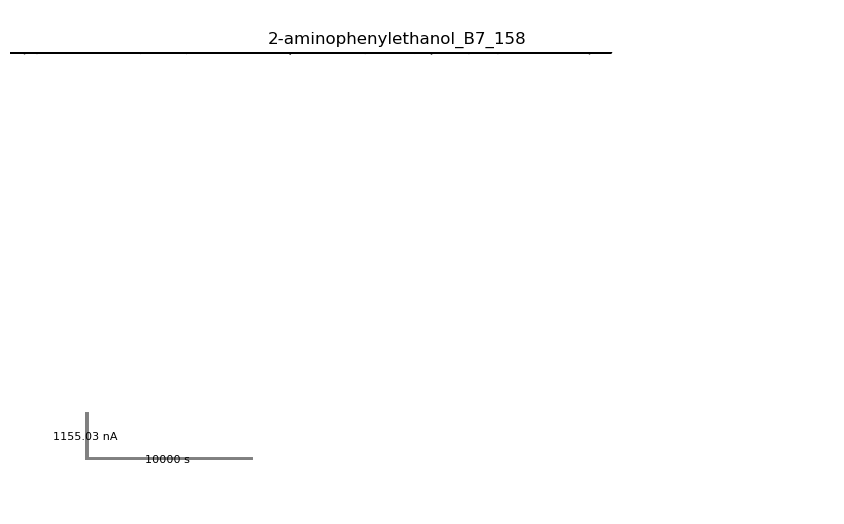

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


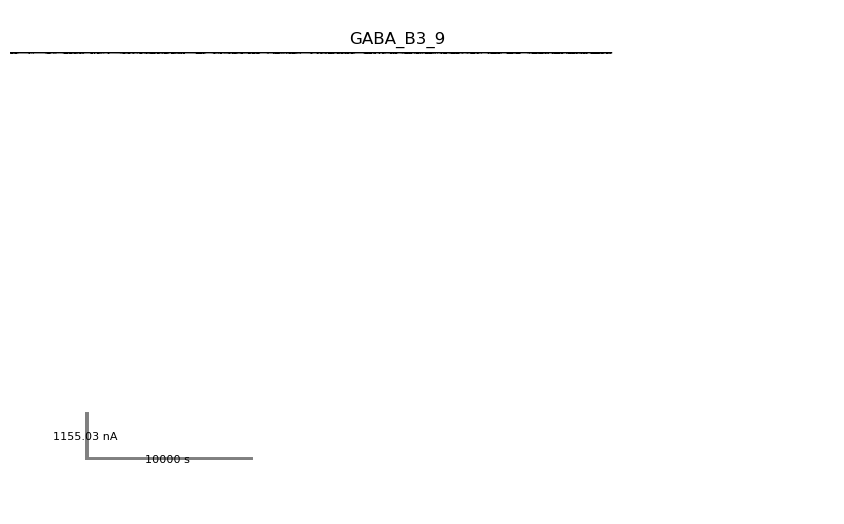

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


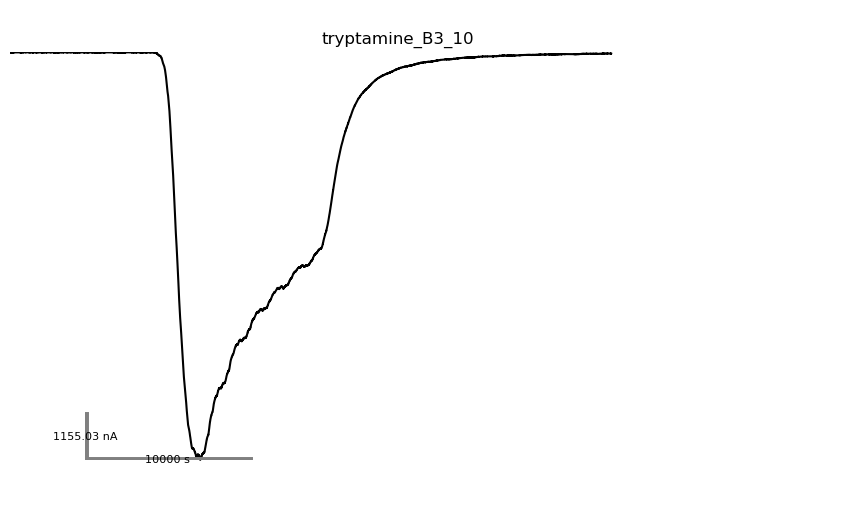

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


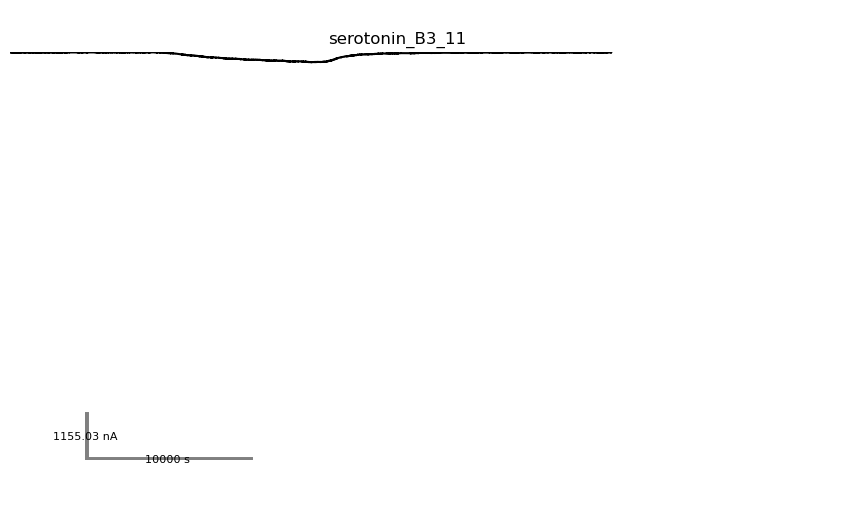

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


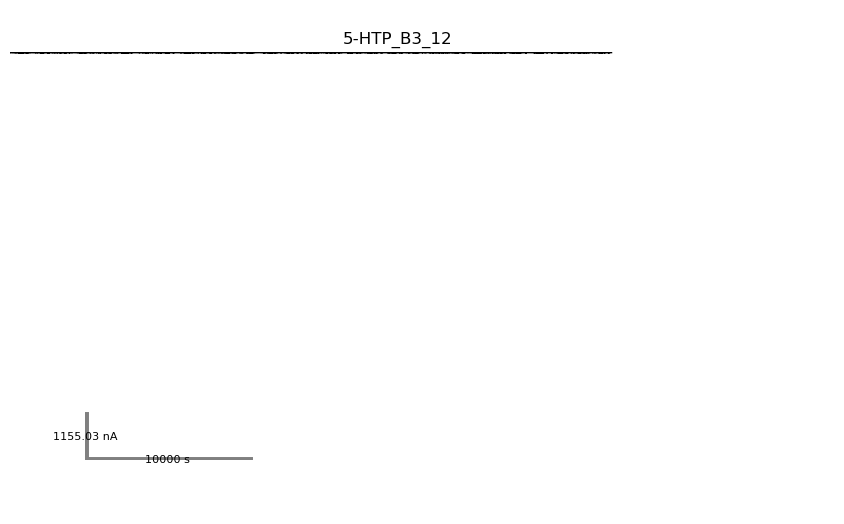

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


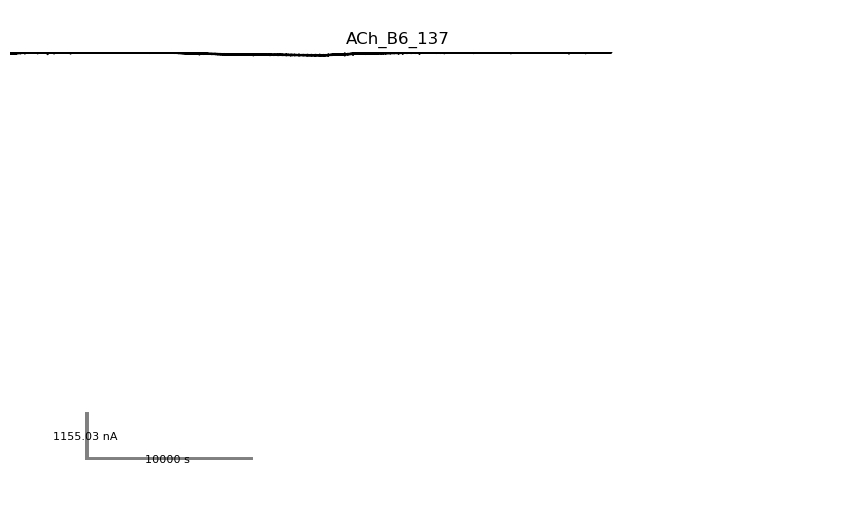

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


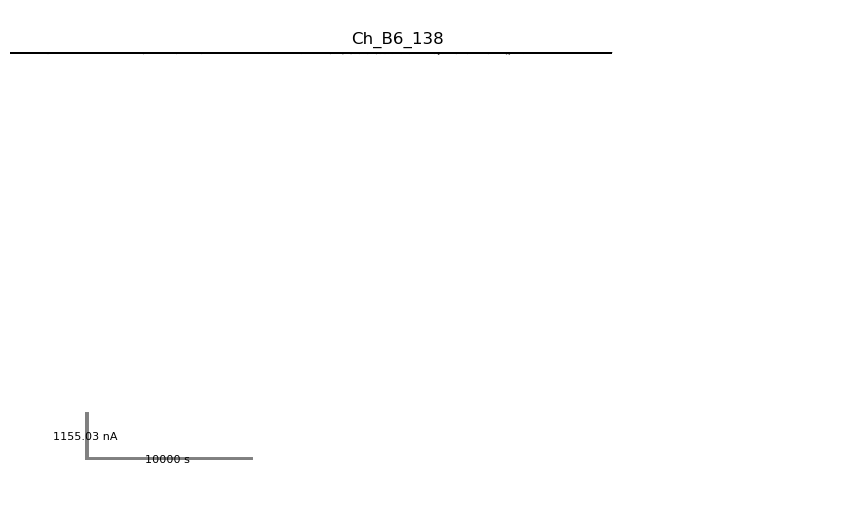

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


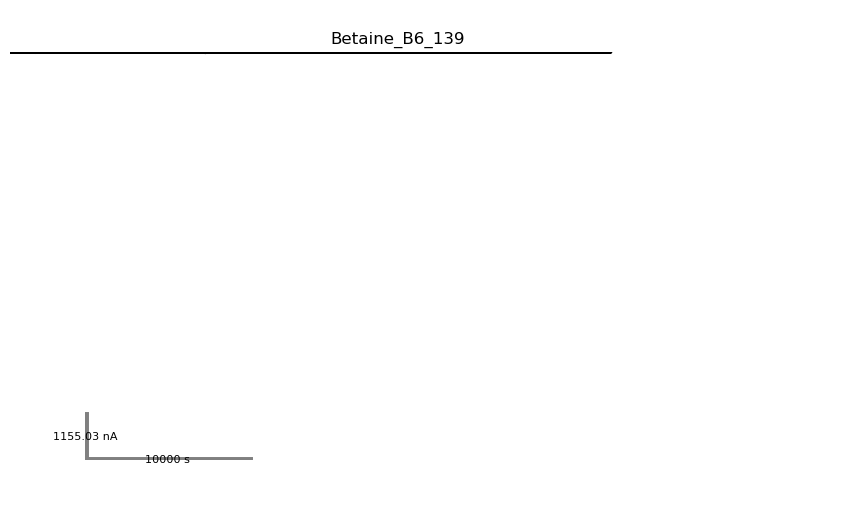

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


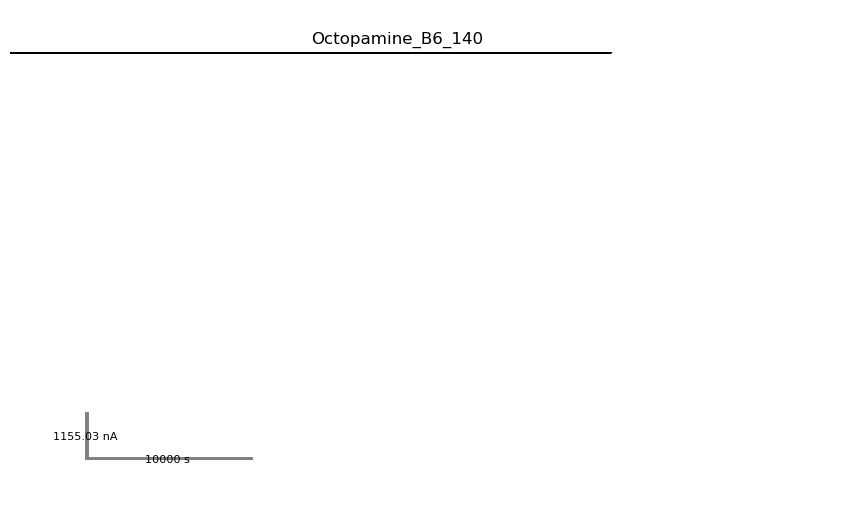

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


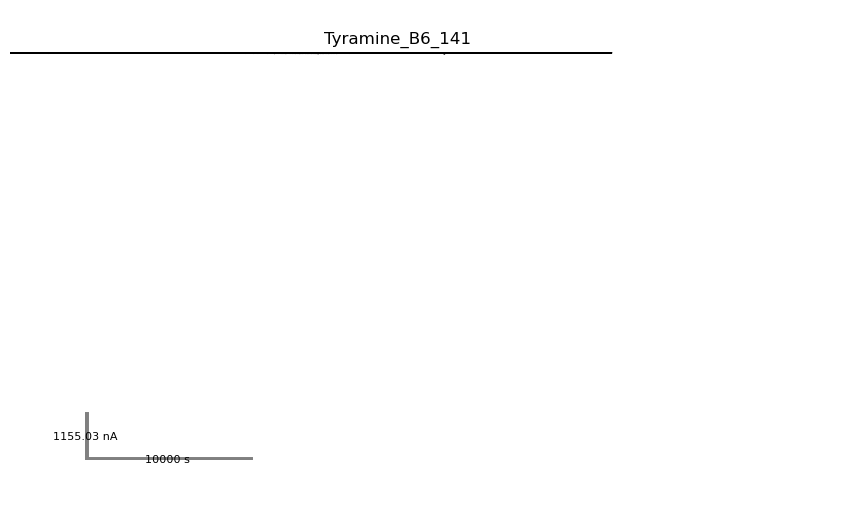

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


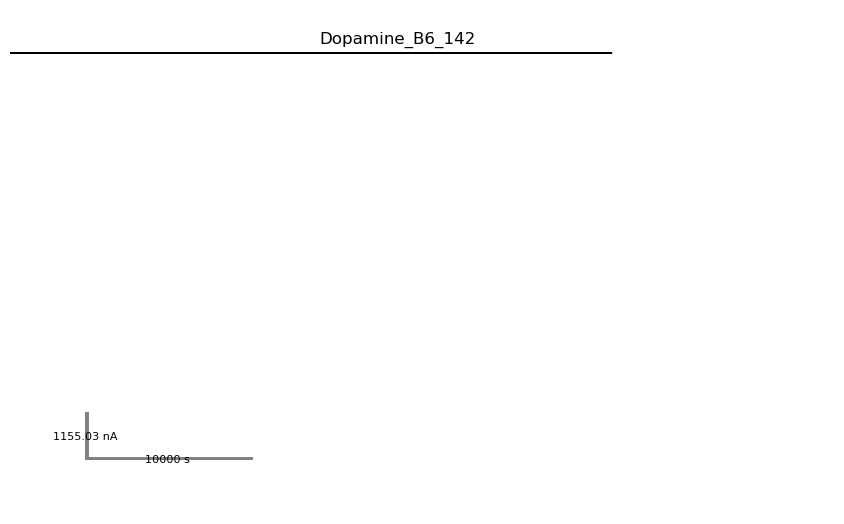

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


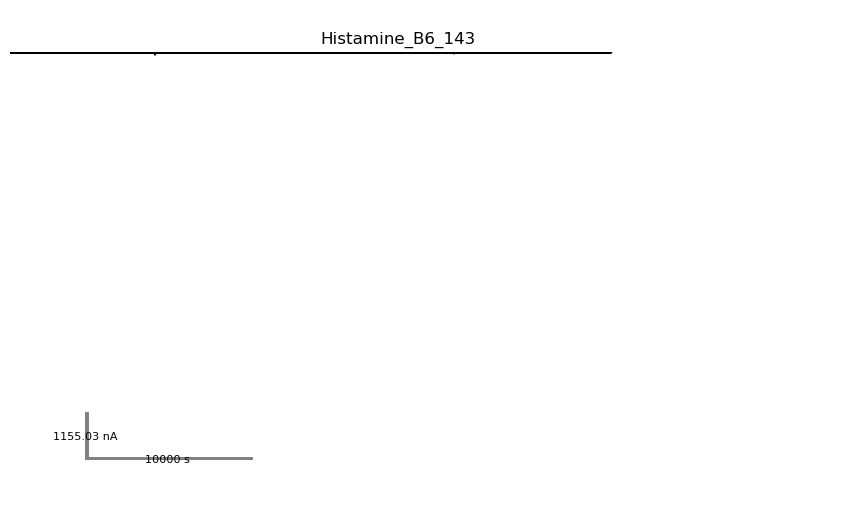

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


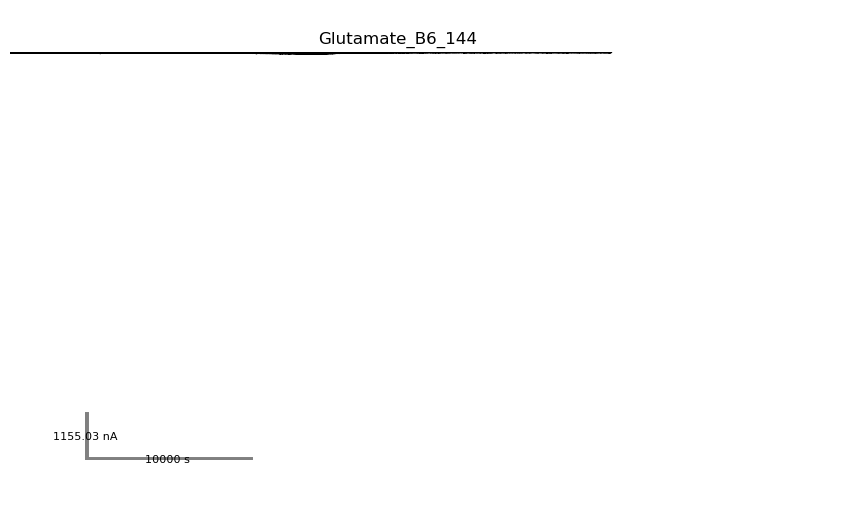

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


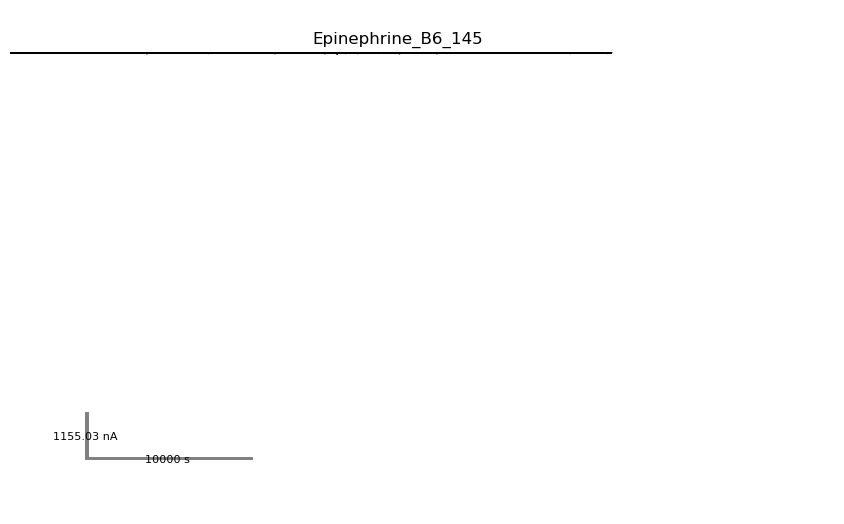

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


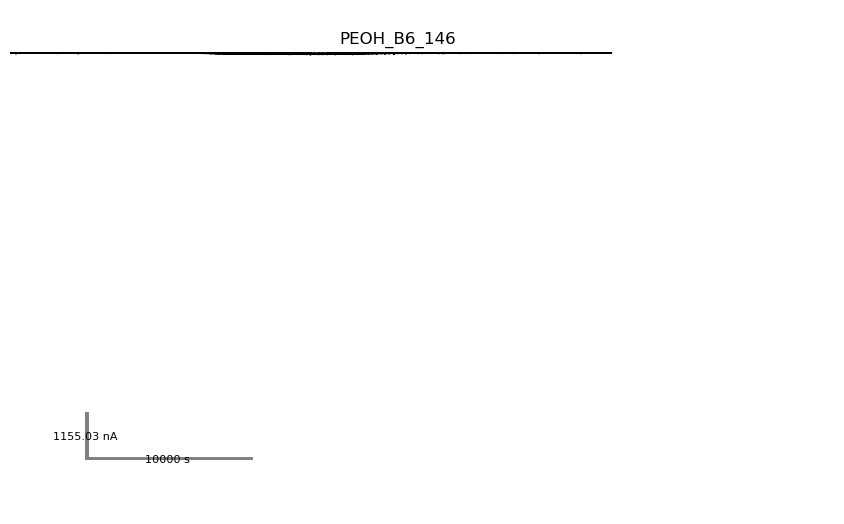

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


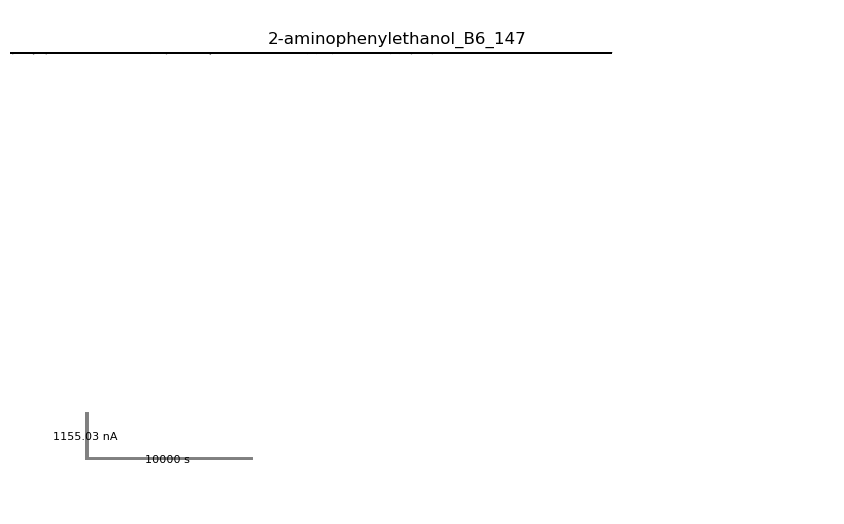

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


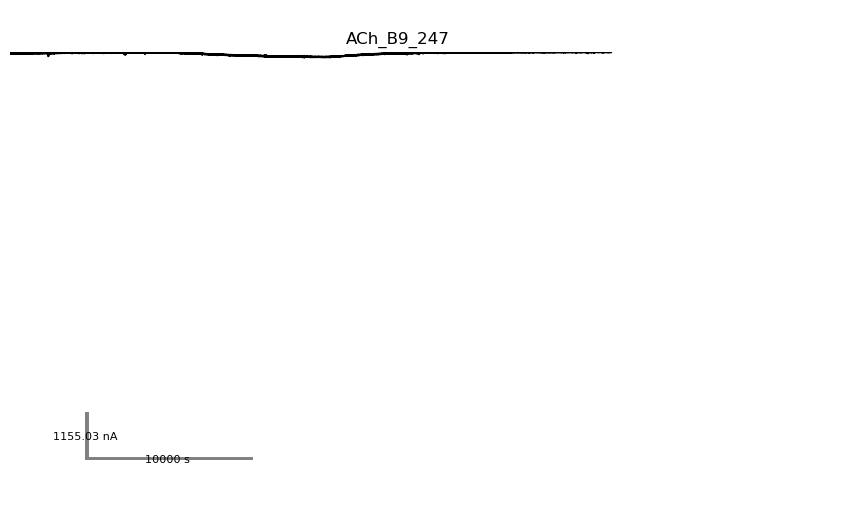

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


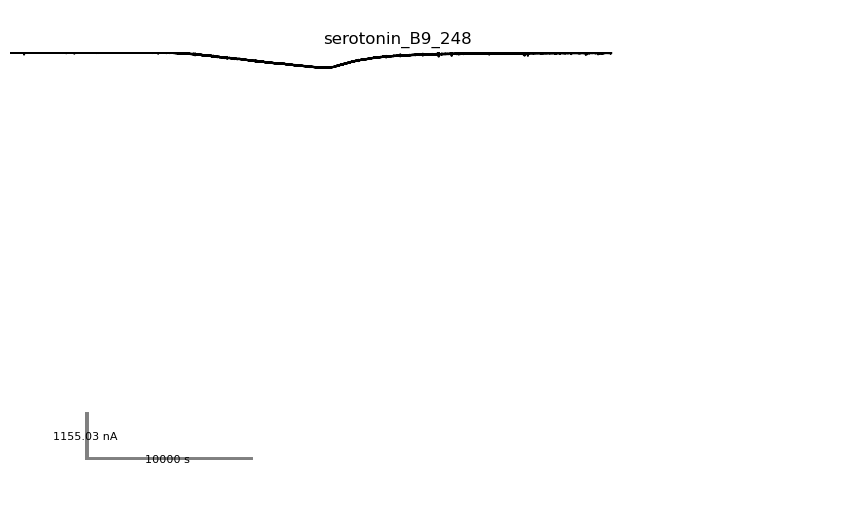

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


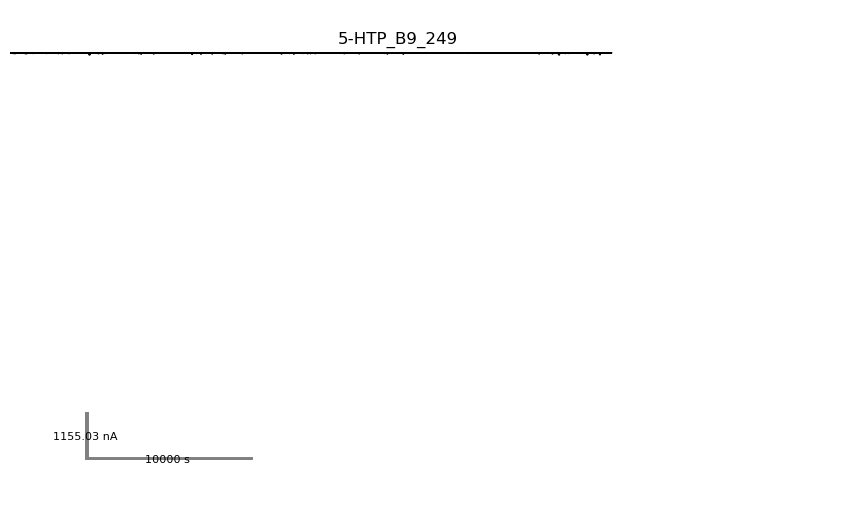

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


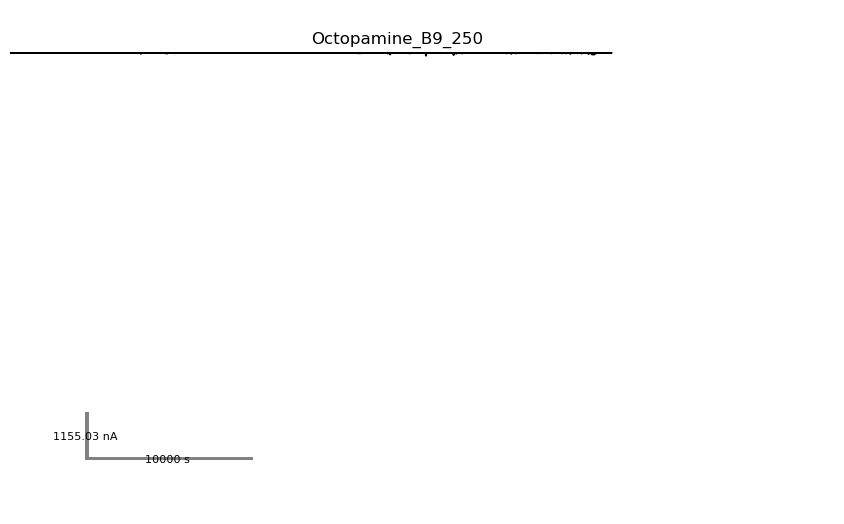

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


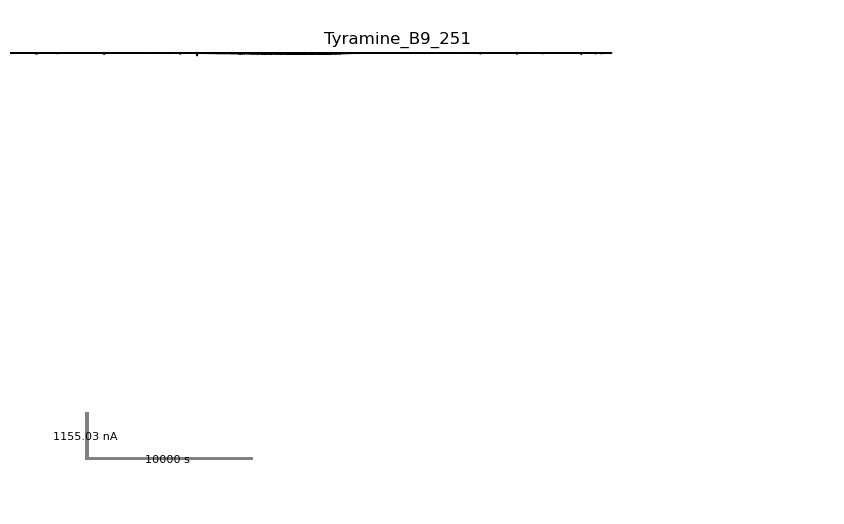

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


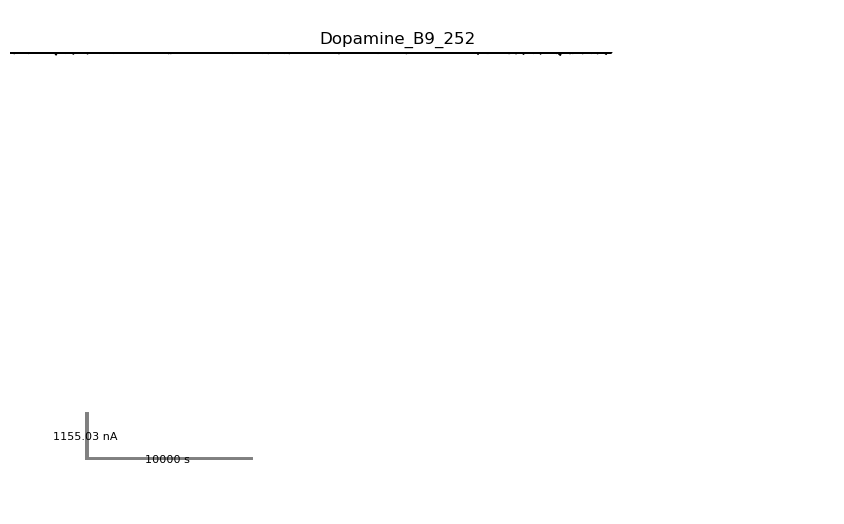

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


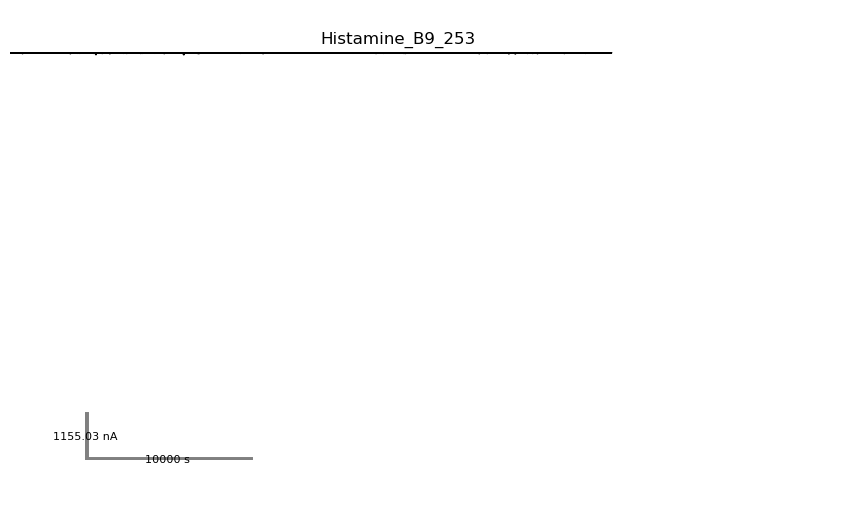

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


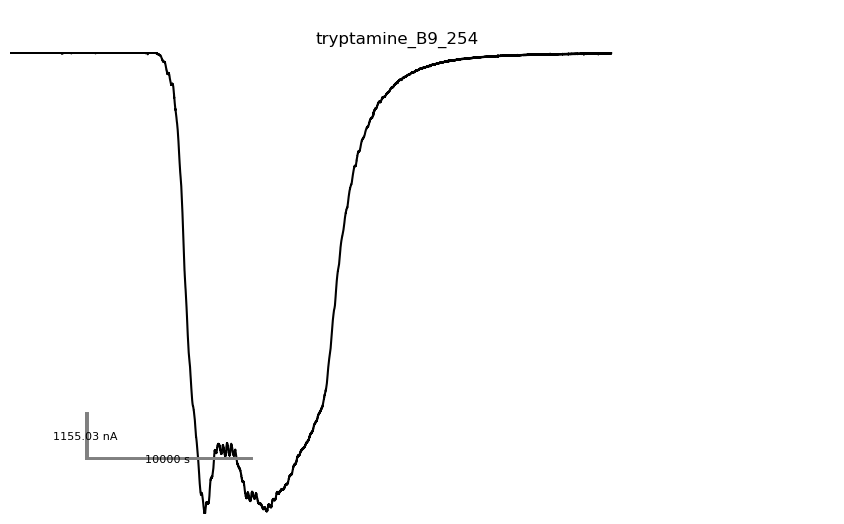

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


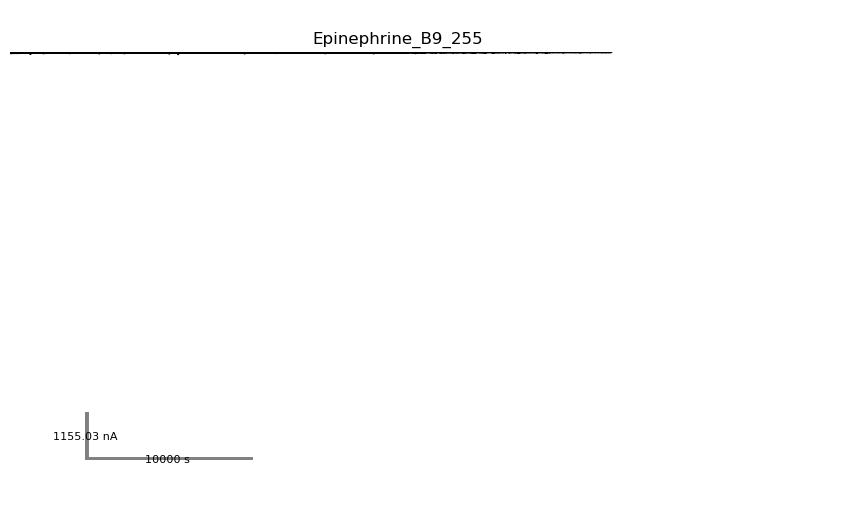

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


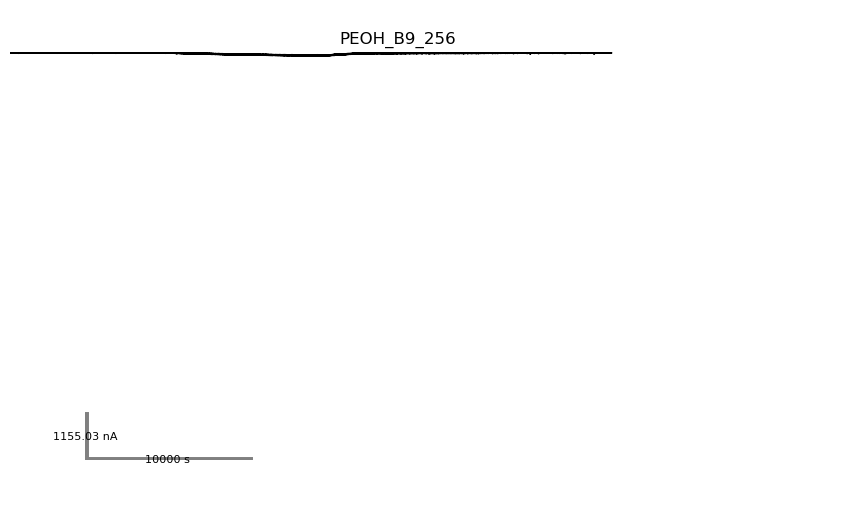

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


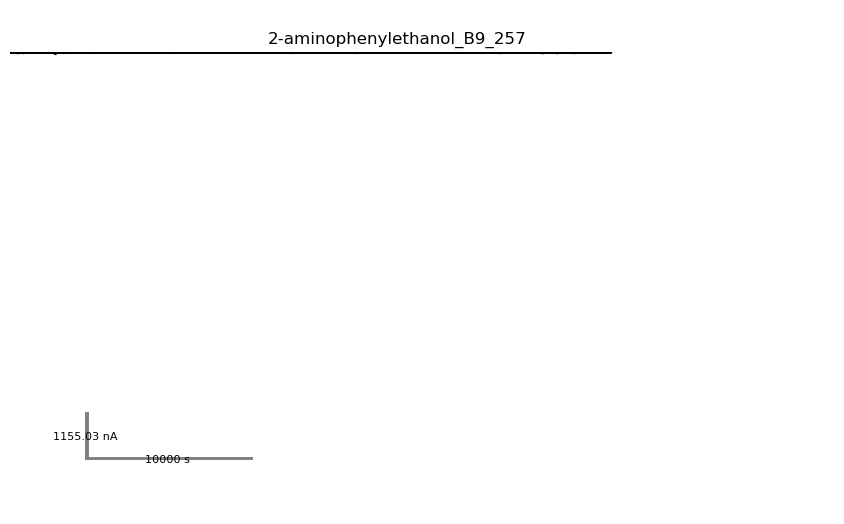

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


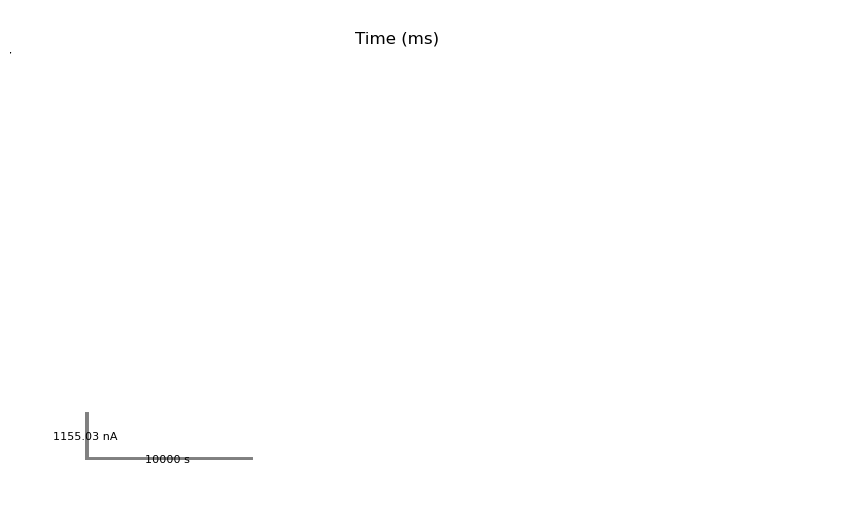

PDF files saved in the /Users/irishardege/Library/CloudStorage/OneDrive-UniversityofCambridge/Zoology/DATA/TEVC/LGC-19/output_plots folder.


In [47]:
#SELECT DATA
df = merged_data_T
merged_data_T = merged_data_T.apply(pd.to_numeric, errors='coerce')

# SAVE PLOTS?
save = True  # Change to False if you don't want to save the plots
# Define scale
maxy = - merged_data_T.min(numeric_only=True, skipna=True).min(skipna=True) #find smallest value in df
maxx = len(df) *2
scale_bar_length = 10*1000 #seconds
scale_bar_height = maxy / 10 #n amps
# Calculate the position and size of the scale bar

# Directory to save PDF files
path2 = Path(path)  # use your path
output_folder = path2 / 'output_plots'

# Create the output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

# Define a function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Apply pd.to_numeric with a custom function to filter non-numeric values for the whole DataFrame
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce').where(x.apply(is_numeric)))

# Drop rows with any NaN values
df = df.dropna()

df['Time (ms)'] = pd.to_numeric(df.index, errors='coerce') *2

# Create a copy of the DataFrame for plotting
df_plot = df.copy()

# Plot each column in a separate figure
for col in df_plot.columns:
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the width and height as needed
    fig.set_size_inches(10, 6)
    ax.plot(df['Time (ms)'], df_plot[col], label=col, color='black')
    ax.set_ylim(-maxy, 10)
    ax.set_xlim(0, maxx)
    # Remove top and right axes lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('nA')
    ax.set_title(col)
    # Create a mini-axes as a scale bar
    scale_bar_axes = fig.add_axes([0.2, 0.2, .75, .75])  # Adjust position and size as needed
    scale_bar_axes.plot([0, scale_bar_length], [0, 0], color='grey', linewidth=5)
    scale_bar_axes.plot([0, 0], [0, scale_bar_height], color='grey', linewidth=5)
    scale_bar_axes.set_xlim(0, maxx)
    scale_bar_axes.set_ylim(0, maxy)
    scale_bar_axes.axis('off')
    # Add text to the scale bar
    text_x_position = (scale_bar_length / 2)  # Center the text
    text_y_position = -2  # Adjust the vertical position
    text2_y_position = (scale_bar_height / 2)  # Center the text
    text2_x_position = -1  # Adjust the vertical position
    scale_bar_axes.text(text_x_position, text_y_position, f'{scale_bar_length} s', color='black', ha='center', va='center', fontsize=8)
    scale_bar_axes.text(text2_x_position, text2_y_position, f'{scale_bar_height} nA', color='black', ha='center', va='center', fontsize=8)

    if save:
        # Save the plot as a PDF in the output folder
        output_filepath = output_folder / f'{col}.pdf'
        plt.savefig(output_filepath, format='pdf')
        plt.show()
        plt.close()  # Close the current figure to release resources
        print(f'PDF files saved in the {output_folder} folder.')
    else:
        # If save is False, just display the plots without saving
        plt.show()
